In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

'''
None || 20000 || 100000
'''
nb = None
nb_trains = nb
nb_valids = nb
nb_tests = nb

N_past = 10

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [3]:
# cd drive/MyDrive/Projects/JPX_Tokyo_Stock/working

In [4]:
# ! pip install optuna

In [5]:
import optuna
from data_utils import *

/home/kienanh/miniconda3/envs/env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load Data

In [6]:
train_df = pd.read_csv('../input/2_after_featureEgineering/' + str(N_past) + '/train_full.csv', parse_dates=['Date'], nrows = nb_trains)
valid_df = pd.read_csv('../input/2_after_featureEgineering/' + str(N_past) + '/valid_full.csv', parse_dates=['Date'], nrows = nb_valids)
test_df = pd.read_csv('../input/2_after_featureEgineering/' + str(N_past) + '/test_full.csv', parse_dates=['Date'], nrows = nb_tests)
y_test_df = pd.read_csv('../input/2_after_featureEgineering/' + str(N_past) + '/y_test_full.csv', parse_dates=['Date'], nrows = nb_tests)

official_test_df = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv', nrows = None, parse_dates=['Date'])

In [7]:
mini_train_after_dataPreprocessing = pd.read_csv('../input/1_after_datapreprocessing/mini_train.csv', parse_dates=['Date'], nrows = None)
mini_train_after_featureEngineering = pd.read_csv('../input/2_after_featureEgineering/' + str(N_past) + '/mini_train.csv', parse_dates=['Date'], nrows = None)

In [8]:
official_test_df = FeatureEgineering_for_official_test(DataPreprocessing_for_official_test(official_test_df, mini_train_after_dataPreprocessing), mini_train_after_featureEngineering, N_past)

/mnt/ee1bd79c-6956-419b-951b-4699528687d7/Project/3. VDT miniPJ/working/data_utils.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return['ExpectedDividend'] = df_return['ExpectedDividend'].fillna(-1)
/home/kienanh/miniconda3/envs/env/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4573509 entries, 0 to 4573508
Data columns (total 64 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Date                datetime64[ns]
 1   SecuritiesCode      int64         
 2   Volume              float64       
 3   AdjustmentFactor    float64       
 4   ExpectedDividend    float64       
 5   SupervisionFlag     bool          
 6   Target              float64       
 7   CloseT2             float64       
 8   Close               float64       
 9   CloseT1             float64       
 10  Range_HL            float64       
 11  Range_OC            float64       
 12  dayofyear           int64         
 13  dayofweek           int64         
 14  week                int64         
 15  is_month_end        bool          
 16  is_month_start      bool          
 17  is_year_end         bool          
 18  is_year_start       bool          
 19  Year                int64         
 20  Mo

In [10]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233223 entries, 0 to 233222
Data columns (total 64 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Date                233223 non-null  datetime64[ns]
 1   SecuritiesCode      233223 non-null  int64         
 2   Volume              233223 non-null  float64       
 3   AdjustmentFactor    233223 non-null  float64       
 4   ExpectedDividend    233223 non-null  float64       
 5   SupervisionFlag     233223 non-null  bool          
 6   Target              233223 non-null  float64       
 7   CloseT2             233223 non-null  float64       
 8   Close               233223 non-null  float64       
 9   CloseT1             233223 non-null  float64       
 10  Range_HL            233223 non-null  float64       
 11  Range_OC            233223 non-null  float64       
 12  dayofyear           233223 non-null  int64         
 13  dayofweek           233223 no

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229952 entries, 0 to 229951
Data columns (total 61 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Date                229952 non-null  datetime64[ns]
 1   SecuritiesCode      229952 non-null  int64         
 2   Volume              229952 non-null  float64       
 3   AdjustmentFactor    229952 non-null  float64       
 4   ExpectedDividend    229952 non-null  float64       
 5   SupervisionFlag     229952 non-null  bool          
 6   Close               229952 non-null  float64       
 7   Range_HL            229952 non-null  float64       
 8   Range_OC            229952 non-null  float64       
 9   dayofyear           229952 non-null  int64         
 10  dayofweek           229952 non-null  int64         
 11  week                229952 non-null  int64         
 12  is_month_end        229952 non-null  bool          
 13  is_month_start      229952 no

In [12]:
y_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229952 entries, 0 to 229951
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   SecuritiesCode  229952 non-null  int64         
 1   Date            229952 non-null  datetime64[ns]
 2   CloseT1         229952 non-null  float64       
 3   CloseT2         229952 non-null  float64       
 4   Target          229952 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 8.8 MB


In [13]:
official_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 61 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                4000 non-null   datetime64[ns]
 1   SecuritiesCode      4000 non-null   int64         
 2   Volume              4000 non-null   float64       
 3   AdjustmentFactor    4000 non-null   float64       
 4   ExpectedDividend    4000 non-null   float64       
 5   SupervisionFlag     4000 non-null   bool          
 6   Close               4000 non-null   float64       
 7   Range_HL            4000 non-null   float64       
 8   Range_OC            4000 non-null   float64       
 9   dayofyear           4000 non-null   int64         
 10  dayofweek           4000 non-null   int64         
 11  week                4000 non-null   UInt32        
 12  is_month_end        4000 non-null   bool          
 13  is_month_start      4000 non-null   bool        

### Calc Scores

In [14]:
def calc_spread_return_per_day(df, portfolio_size: int = 200, toprank_weight_ratio: float = 2):
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): spread return
    """
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    buf = df.groupby('Date').apply(calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio, buf

def add_rank(df: pd.DataFrame, y_pred):
    df["Pred"] = y_pred
    df["Rank"] = df.groupby("Date")["Pred"].rank(ascending=False, method="first") - 1 
    df = df.drop("Pred", axis= 1)
    return df

In [15]:
def calc_score(df: pd.DataFrame, y_pred: pd.DataFrame, y_true: pd.DataFrame, render_info= True):
    feature_df = df.copy()
    feature_df = add_rank(feature_df, y_pred)
    feature_df['Target'] = y_true
    score, buf = calc_spread_return_sharpe(feature_df)
    if render_info:
        print(f'score -> {score}\nmean -> {buf.mean()}\nstd -> {buf.std()}')
    del feature_df
    return score

In [16]:
# This function adjusts the predictions so that the daily spread return approaches a certain value.
def adjuster(df):
    def calc_pred(df, x, y, z):
        return df['Target'].where(df['Target'].abs() < x, df['Target'] * y + np.sign(df['Target']) * z)

    def objective(trial, df):
        x = trial.suggest_uniform('x', 0, 0.2)
        y = trial.suggest_uniform('y', 0, 0.1)
        z = trial.suggest_uniform('z', 0, 1e-3)
        df["Rank"] = calc_pred(df, x, y, z).rank(ascending=False, method="first") - 1 
        df["Rank"] = df["Rank"].astype("int")
        return calc_spread_return_per_day(df, 200, 2)
    
    def predictor_per_day(df):
        study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=2022))
        study.optimize(lambda trial: abs(objective(trial, df) - 3), 3)
        return calc_pred(df, *study.best_params.values())

    return df.groupby("Date").apply(predictor_per_day).reset_index(level=0, drop=True)

def _predictor_model(model, feature_df):
    return model.predict(feature_df)

def _predictor_model_with_adjuster(model, _df: pd.DataFrame):
    df = _df.copy()
    df["Target"] = model.predict(df.drop('Date', axis = 1))
    pred = adjuster(df).iloc[0]
    return pred

def _predictor_adjuster_pred(_df: pd.DataFrame, pred):
    df = _df.copy()
    df["Target"] = pred
    new_pred = adjuster(df).iloc[0]
    return new_pred

In [17]:
calc_score(test_df, y_test_df["Target"], y_test_df["Target"])

score -> 4.687380919991681
mean -> 15.4462416034095
std -> 3.295281921196392


4.687380919991681

#### Cross Validation

In [18]:
list_code = train_df['SecuritiesCode'].unique()
list_code

array([1301, 1332, 1333, ..., 2648, 2961, 9250])

In [20]:
# np.random.shuffle(list_code)
# list_code

# K_code_set = list(list_code[:1800].reshape((50, 36)))
# pd.DataFrame(
#     np.array(K_code_set), 
#     columns= ['Code_' + str(i) for i in range(len(K_code_set[0]))]
# ).to_csv('./K_code_set.csv', index= False)
# K_code_set

In [21]:
K_code_set = pd.read_csv('./K_code_set.csv')
K_code_set

,Code_0,Code_1,Code_2,Code_3,Code_4,Code_5,Code_6,Code_7,Code_8,Code_9,...,Code_26,Code_27,Code_28,Code_29,Code_30,Code_31,Code_32,Code_33,Code_34,Code_35
0,1394,2629,6569,4642,2185,3847,8604,1815,6616,4098,...,3655,1770,8871,3341,7729,6199,3766,3174,1764,8706
1,7942,4666,1301,4570,6217,1919,2207,9263,7544,4750,...,6741,7172,6951,3073,8088,7874,4673,9849,4980,3123
2,3023,7060,7087,9632,4045,4960,6493,6772,3087,8596,...,8274,7038,4235,3741,9793,2304,7581,9176,3193,4248
3,4192,7862,9761,4492,7914,7605,9474,1884,9068,9895,...,3663,2877,7995,3042,5476,3245,4461,5816,7041,9133
4,3065,6966,6898,2531,7771,2479,6849,3845,3802,8138,...,5491,7607,4881,8219,2060,3189,7516,2563,1931,6502
5,4875,3964,2001,5965,4429,6871,6138,4369,2780,1401,...,3632,3583,6806,8686,7846,6590,9419,9504,8163,2114
6,4304,7271,4999,5214,1446,2031,8685,7606,7972,7965,...,5283,5902,7079,6834,3333,2726,2737,8933,1571,9631
7,8955,9735,7709,4061,8367,7745,3469,2282,8194,5280,...,6022,1459,5289,4324,7564,2047,6315,2668,3557,7531
8,4033,2341,9955,9376,8938,3183,8876,8473,7609,9507,...,5659,4921,3719,6632,2291,3143,5947,3161,7035,9432
9,8700,2315,7638,8349,7915,2335,5351,3661,7871,3800,...,4975,2622,6947,6852,9385,4409,2459,1550,3277,4221


In [22]:
K_code_set = list(np.array(K_code_set))
K_code_set

[array([1394, 2629, 6569, 4642, 2185, 3847, 8604, 1815, 6616, 4098, 9740,
        4617, 3445, 3834, 6194, 7624, 6069, 8360, 9993, 8191, 2480, 3936,
        1965, 8025, 1691, 4714, 3655, 1770, 8871, 3341, 7729, 6199, 3766,
        3174, 1764, 8706]),
 array([7942, 4666, 1301, 4570, 6217, 1919, 2207, 9263, 7544, 4750, 9832,
        3994, 3028, 7807, 9361, 7561, 2498, 2918, 2972, 6335, 7071, 6819,
        7895, 3542, 3515, 8072, 6741, 7172, 6951, 3073, 8088, 7874, 4673,
        9849, 4980, 3123]),
 array([3023, 7060, 7087, 9632, 4045, 4960, 6493, 6772, 3087, 8596, 4341,
        9656, 6989, 6433, 6553, 6866, 5449, 6486, 6647, 9278, 7370, 8537,
        6365, 6815, 4968, 7722, 8274, 7038, 4235, 3741, 9793, 2304, 7581,
        9176, 3193, 4248]),
 array([4192, 7862, 9761, 4492, 7914, 7605, 9474, 1884, 9068, 9895, 4231,
        9997, 3168, 3295, 9764, 4434, 6645, 4734, 9628, 1775, 9878, 7810,
        6049, 2587, 9837, 7922, 3663, 2877, 7995, 3042, 5476, 3245, 4461,
        5816, 7041, 9133]),


In [23]:
def find_datapoints_in_list(list_code, df: pd.DataFrame):
    return df[df['SecuritiesCode'].isin(list_code)].reset_index(drop= True)

In [24]:
find_datapoints_in_list(K_code_set[1], train_df)

,Date,SecuritiesCode,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,CloseT2,Close,CloseT1,...,Close_9_before,Range_HL_9_before,Range_OC_9_before,Volume_9_before,Close_10_before,Range_HL_10_before,Range_OC_10_before,Volume_10_before,Close_mean,Close_std
0,2017-01-19,1301,9.487972,1.0,-1.0,False,-0.006211,-0.115673,-1.037067,0.630218,...,0.674094,0.526511,0.219380,9.792556,0.849597,1.096898,-0.351007,10.354563,2722.636364,22.791545
1,2017-01-19,2207,9.705037,1.0,-1.0,False,-0.007812,-1.179855,1.307672,0.009832,...,-1.179855,1.297840,-0.540767,9.615805,-1.828775,0.757074,0.108153,9.820106,1407.909091,9.246129
2,2017-01-19,2498,7.090077,1.0,-1.0,False,-0.003250,-1.308142,-1.029275,-1.140822,...,1.201666,0.557735,-0.278868,9.568015,0.811251,1.059697,-1.003923,9.425452,943.454545,17.929661
3,2017-01-19,2918,10.281924,1.0,-1.0,False,-0.015548,-1.984190,-0.565156,-0.700302,...,0.043001,1.047382,0.608157,10.561008,0.347080,1.655539,0.000000,10.896739,2464.727273,29.597604
4,2017-01-19,3028,11.034890,1.0,-1.0,False,-0.013834,-1.351376,-0.681608,-0.830445,...,1.457930,0.706978,-0.074419,11.542484,1.327697,1.079071,-0.893024,11.963364,2068.636364,53.749926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37829,2021-12-03,7561,9.661416,1.0,-1.0,False,0.030233,-0.661406,-1.914802,-1.914802,...,0.849098,0.285921,0.095307,8.556414,0.658484,0.381228,0.095307,8.575462,455.090909,10.492422
37830,2021-12-03,7807,9.384294,1.0,-1.0,False,0.010684,-0.825160,-1.103706,-1.103706,...,0.910430,0.307715,0.111896,9.239899,1.022326,0.391637,0.083922,9.588777,971.454545,35.747346
37831,2021-12-03,7895,8.216088,1.0,-1.0,False,-0.005168,-0.588115,-0.450035,-0.450035,...,0.702794,0.610321,0.135627,8.556414,0.838421,0.881575,-0.135627,9.071078,400.636364,14.746340
37832,2021-12-03,9263,11.602766,1.0,-1.0,False,0.029289,-0.301649,-0.861058,-0.861058,...,0.469668,0.547946,0.234834,11.895463,0.939336,0.469668,0.000000,11.685197,255.000000,12.774976


In [25]:
K_train = []

In [26]:
for code_set in K_code_set:
    K_train.append(find_datapoints_in_list(code_set, train_df))

In [27]:
len(K_train), [len(K_train[i]) for i in range(len(K_train))]

(50,
 [38787,
  37834,
  38438,
  37799,
  37195,
  40221,
  40029,
  38775,
  40281,
  40476,
  37405,
  34012,
  36562,
  34611,
  37509,
  38173,
  37609,
  37118,
  35636,
  38278,
  36743,
  37994,
  38334,
  39471,
  37349,
  36528,
  40990,
  38939,
  38626,
  37723,
  40428,
  39504,
  36983,
  38286,
  35178,
  36909,
  36981,
  36809,
  40334,
  40414,
  34604,
  37365,
  39692,
  33774,
  39416,
  33068,
  35254,
  35825,
  37977,
  38316])

In [28]:
featureCols = train_df.drop(["Target", "CloseT1", "CloseT2"], axis = 1).columns
featureCols

Index(['Date', 'SecuritiesCode', 'Volume', 'AdjustmentFactor',
       'ExpectedDividend', 'SupervisionFlag', 'Close', 'Range_HL', 'Range_OC',
       'dayofyear', 'dayofweek', 'week', 'is_month_end', 'is_month_start',
       'is_year_end', 'is_year_start', 'Year', 'Month', 'Day',
       'Close_1_before', 'Range_HL_1_before', 'Range_OC_1_before',
       'Volume_1_before', 'Close_2_before', 'Range_HL_2_before',
       'Range_OC_2_before', 'Volume_2_before', 'Close_3_before',
       'Range_HL_3_before', 'Range_OC_3_before', 'Volume_3_before',
       'Close_4_before', 'Range_HL_4_before', 'Range_OC_4_before',
       'Volume_4_before', 'Close_5_before', 'Range_HL_5_before',
       'Range_OC_5_before', 'Volume_5_before', 'Close_6_before',
       'Range_HL_6_before', 'Range_OC_6_before', 'Volume_6_before',
       'Close_7_before', 'Range_HL_7_before', 'Range_OC_7_before',
       'Volume_7_before', 'Close_8_before', 'Range_HL_8_before',
       'Range_OC_8_before', 'Volume_8_before', 'Close_9_be

In [29]:
X_train = train_df[featureCols]
X_train["Date"] = X_train["Date"].astype(str)
y_train = train_df["Target"]

X_valid = valid_df[featureCols]
X_valid["Date"] = X_valid["Date"].astype(str)
y_valid = valid_df["Target"]

/home/kienanh/miniconda3/envs/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/kienanh/miniconda3/envs/env/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
# break point
1/0

ZeroDivisionError: division by zero

#### Optuna tuning

In [ ]:
x_train_optuna = pd.DataFrame()
y_train_optuna = pd.DataFrame()
x_eval_optuna = X_valid
x_eval_not_date = X_valid.drop("Date", axis = 1)
y_eval_optuna = y_valid

In [ ]:
model = xgb.XGBRegressor()

In [ ]:
def objective(
    trial,
    random_state=22,
    n_jobs=-1,
):
    # XGBoost parameters
    params = {
        'tree_method':'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "objective": "reg:squarederror",
        "n_estimators": 1000,
        "max_depth": trial.suggest_int("max_depth", 11, 25),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
        "subsample": trial.suggest_loguniform("subsample", 0.6, 0.8),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "gamma": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 1000),
        "seed": random_state,
        "n_jobs": n_jobs,
        "early_stopping_rounds": 50,
        "eval_metric": "rmse"
        
    }

    global model
    model = xgb.XGBRegressor(**params) 

    model.fit(
        x_train_optuna,
        y_train_optuna,
        eval_set=[(x_eval_not_date, y_eval_optuna)],
        verbose=0,
    )
    y_pred = pd.DataFrame(model.predict(x_eval_not_date), columns =['Target'])
    return calc_score(x_eval_optuna, y_pred, y_eval_optuna, render_info= False)

In [ ]:
study_set = []
feature_important_list = pd.DataFrame(columns= x_train_optuna.columns)
feature_important_list

""


In [ ]:
for idx, train_set in enumerate(K_train):
    x_train_optuna = train_set[featureCols].drop("Date", axis = 1)
    y_train_optuna = train_set["Target"]

    print("set " + str(idx) + "_th")
    study_set.append(optuna.create_study(direction='maximize'))
    study_set[idx].optimize(objective, n_trials=10, gc_after_trial=True)

    feature_important_list = feature_important_list.append(pd.DataFrame(model.feature_importances_.reshape(1, -1), columns= x_train_optuna.columns))


[I 2022-06-18 20:05:16,047] A new study created in memory with name: no-name-cc8401bf-36e1-43be-b47e-a82255d49759


set 0_th


[I 2022-06-18 20:05:27,929] Trial 0 finished with value: 0.21550677707155821 and parameters: {'max_depth': 14, 'learning_rate': 0.008669320279366838, 'colsample_bytree': 0.2551729338407417, 'subsample': 0.6060619409432271, 'alpha': 0.4351868097944178, 'lambda': 0.2257897528036976, 'min_child_weight': 181.1474684560403}. Best is trial 0 with value: 0.21550677707155821.
[I 2022-06-18 20:05:39,448] Trial 1 finished with value: 0.18438581681146074 and parameters: {'max_depth': 11, 'learning_rate': 0.030777804286618773, 'colsample_bytree': 0.3160644533752104, 'subsample': 0.7778408524597489, 'alpha': 0.0650856579861905, 'lambda': 9.356923207975017e-08, 'min_child_weight': 158.8825695528441}. Best is trial 0 with value: 0.21550677707155821.
[I 2022-06-18 20:05:50,518] Trial 2 finished with value: 0.19578420933665175 and parameters: {'max_depth': 14, 'learning_rate': 0.005668405177116395, 'colsample_bytree': 0.33586633318388814, 'subsample': 0.6647563114573853, 'alpha': 0.8044683400961371, 'l

set 1_th


[I 2022-06-18 20:11:29,116] Trial 0 finished with value: 0.04535612120359391 and parameters: {'max_depth': 24, 'learning_rate': 0.013638034172472531, 'colsample_bytree': 0.28903209410505837, 'subsample': 0.6296823302632697, 'alpha': 0.021137287674955096, 'lambda': 0.020097920842741424, 'min_child_weight': 152.039035522013}. Best is trial 0 with value: 0.04535612120359391.
[I 2022-06-18 20:11:40,462] Trial 1 finished with value: 0.0717634829080817 and parameters: {'max_depth': 11, 'learning_rate': 0.03624119617769625, 'colsample_bytree': 0.3680896704867605, 'subsample': 0.6364881692499248, 'alpha': 9.096715104043524, 'lambda': 2.8179050367836683e-07, 'min_child_weight': 147.73144643294802}. Best is trial 1 with value: 0.0717634829080817.
[I 2022-06-18 20:11:58,920] Trial 2 finished with value: 0.14071886062916464 and parameters: {'max_depth': 15, 'learning_rate': 0.043612811606283344, 'colsample_bytree': 0.23825204753472481, 'subsample': 0.611856404505878, 'alpha': 0.1450603893208405, '

set 2_th


[I 2022-06-18 20:16:49,979] Trial 0 finished with value: 0.209464100568238 and parameters: {'max_depth': 11, 'learning_rate': 0.013938748348345763, 'colsample_bytree': 0.4904054630190488, 'subsample': 0.7022606514109015, 'alpha': 0.09692476571404576, 'lambda': 2.760299509604223, 'min_child_weight': 583.0631601324989}. Best is trial 0 with value: 0.209464100568238.
[I 2022-06-18 20:17:10,927] Trial 1 finished with value: 0.2646750943696091 and parameters: {'max_depth': 18, 'learning_rate': 0.03122449292684674, 'colsample_bytree': 0.5629098737929179, 'subsample': 0.6199064674574352, 'alpha': 0.45309542283983534, 'lambda': 0.0006739270504635693, 'min_child_weight': 77.45049141500184}. Best is trial 1 with value: 0.2646750943696091.
[I 2022-06-18 20:18:06,276] Trial 2 finished with value: 0.24753701058109204 and parameters: {'max_depth': 18, 'learning_rate': 0.03801116635521625, 'colsample_bytree': 0.50842009807417, 'subsample': 0.6738808470936554, 'alpha': 0.06452986080130838, 'lambda': 9

set 3_th


[I 2022-06-18 20:30:28,922] Trial 0 finished with value: 0.04805183810900244 and parameters: {'max_depth': 15, 'learning_rate': 0.023569505537440024, 'colsample_bytree': 0.2200145850416996, 'subsample': 0.6114597239021986, 'alpha': 0.23981472441965462, 'lambda': 9.378322385406479, 'min_child_weight': 601.707952333624}. Best is trial 0 with value: 0.04805183810900244.
[I 2022-06-18 20:35:52,519] Trial 1 finished with value: 0.07318807177305806 and parameters: {'max_depth': 25, 'learning_rate': 0.0493378181541652, 'colsample_bytree': 0.46001085220005944, 'subsample': 0.6314834607963321, 'alpha': 3.0284742525416948, 'lambda': 0.00013958181362098217, 'min_child_weight': 17.992731212934167}. Best is trial 1 with value: 0.07318807177305806.
[I 2022-06-18 20:36:02,682] Trial 2 finished with value: 0.035747233090089495 and parameters: {'max_depth': 12, 'learning_rate': 0.04323262694451326, 'colsample_bytree': 0.5279188304470327, 'subsample': 0.6604525638331333, 'alpha': 0.14517473422897947, 'l

set 4_th


[I 2022-06-18 20:42:48,779] Trial 0 finished with value: 0.2588283979372817 and parameters: {'max_depth': 21, 'learning_rate': 0.024255725510798954, 'colsample_bytree': 0.3810014537731828, 'subsample': 0.6653852527543778, 'alpha': 0.055267234845618234, 'lambda': 0.03809229505555708, 'min_child_weight': 452.82977810296813}. Best is trial 0 with value: 0.2588283979372817.
[I 2022-06-18 20:42:59,989] Trial 1 finished with value: 0.253833438650892 and parameters: {'max_depth': 18, 'learning_rate': 0.00522772586523587, 'colsample_bytree': 0.27436854799991917, 'subsample': 0.71905733439139, 'alpha': 0.48710008098150936, 'lambda': 0.12353056737548876, 'min_child_weight': 296.16406805031914}. Best is trial 0 with value: 0.2588283979372817.
[I 2022-06-18 20:48:01,812] Trial 2 finished with value: 0.31360734172298294 and parameters: {'max_depth': 25, 'learning_rate': 0.02583941770357331, 'colsample_bytree': 0.3267533402334586, 'subsample': 0.6758509822869149, 'alpha': 4.259753192749411, 'lambda'

set 5_th


[I 2022-06-18 20:52:16,532] Trial 0 finished with value: 0.2270484711813764 and parameters: {'max_depth': 14, 'learning_rate': 0.03449120172169826, 'colsample_bytree': 0.29776194886756224, 'subsample': 0.7510149179847572, 'alpha': 2.1284265588982967, 'lambda': 0.037466818027312304, 'min_child_weight': 46.8954975093472}. Best is trial 0 with value: 0.2270484711813764.
[I 2022-06-18 20:52:33,821] Trial 1 finished with value: 0.24681170341380484 and parameters: {'max_depth': 19, 'learning_rate': 0.030143466449944943, 'colsample_bytree': 0.32517359234497245, 'subsample': 0.6204307787992054, 'alpha': 0.3875142847426797, 'lambda': 3.4018104101594117e-06, 'min_child_weight': 193.25219664488654}. Best is trial 1 with value: 0.24681170341380484.
[I 2022-06-18 20:52:42,982] Trial 2 finished with value: 0.1717587762202874 and parameters: {'max_depth': 12, 'learning_rate': 0.01700975126558628, 'colsample_bytree': 0.3512780194652938, 'subsample': 0.6654854531832636, 'alpha': 1.2420168500984334, 'la

set 6_th


[I 2022-06-18 21:03:30,129] Trial 0 finished with value: 0.08719445191626145 and parameters: {'max_depth': 23, 'learning_rate': 0.04681056645820133, 'colsample_bytree': 0.3374213823598723, 'subsample': 0.605626840033468, 'alpha': 0.1732372710028756, 'lambda': 1.1419752547365251e-05, 'min_child_weight': 87.57473392505841}. Best is trial 0 with value: 0.08719445191626145.
[I 2022-06-18 21:03:43,820] Trial 1 finished with value: 0.1660975022777673 and parameters: {'max_depth': 13, 'learning_rate': 0.009334147621817486, 'colsample_bytree': 0.28331515197311913, 'subsample': 0.7271479018437279, 'alpha': 1.8806677522854773, 'lambda': 9.691510205266685e-07, 'min_child_weight': 105.89379588831018}. Best is trial 1 with value: 0.1660975022777673.
[I 2022-06-18 21:03:57,593] Trial 2 finished with value: 0.03280373322043859 and parameters: {'max_depth': 16, 'learning_rate': 0.02443100489736329, 'colsample_bytree': 0.367666634278901, 'subsample': 0.6536416307946344, 'alpha': 2.437067016621264, 'lam

set 7_th


[I 2022-06-18 21:08:55,812] Trial 0 finished with value: 0.19201479663100232 and parameters: {'max_depth': 14, 'learning_rate': 0.006214333346107792, 'colsample_bytree': 0.20770378006552925, 'subsample': 0.6851132160666874, 'alpha': 0.5450511693810581, 'lambda': 1.2042070827720827e-06, 'min_child_weight': 12.322574110162119}. Best is trial 0 with value: 0.19201479663100232.
[I 2022-06-18 21:09:21,989] Trial 1 finished with value: 0.21532399286678544 and parameters: {'max_depth': 20, 'learning_rate': 0.006554111319128954, 'colsample_bytree': 0.2933721830170273, 'subsample': 0.6933388307341131, 'alpha': 0.4730161511204483, 'lambda': 1.0758989042033292e-07, 'min_child_weight': 83.80762807342686}. Best is trial 1 with value: 0.21532399286678544.
[I 2022-06-18 21:14:03,222] Trial 2 finished with value: 0.026280537625485993 and parameters: {'max_depth': 25, 'learning_rate': 0.019624814638690324, 'colsample_bytree': 0.40563845109985414, 'subsample': 0.7965721515997699, 'alpha': 0.040727414888

set 8_th


[I 2022-06-18 21:16:20,862] Trial 0 finished with value: 0.3197879083173795 and parameters: {'max_depth': 15, 'learning_rate': 0.04636528726193784, 'colsample_bytree': 0.23847871706808133, 'subsample': 0.7755867146950357, 'alpha': 2.630339180613706, 'lambda': 9.90960663651935e-08, 'min_child_weight': 47.908181790483496}. Best is trial 0 with value: 0.3197879083173795.
[I 2022-06-18 21:21:14,587] Trial 1 finished with value: 0.25236667545481634 and parameters: {'max_depth': 25, 'learning_rate': 0.009001043532537665, 'colsample_bytree': 0.526406312651152, 'subsample': 0.6054159860862992, 'alpha': 4.139965655973162, 'lambda': 0.049229685639665496, 'min_child_weight': 76.25929415143713}. Best is trial 0 with value: 0.3197879083173795.
[I 2022-06-18 21:21:24,957] Trial 2 finished with value: 0.17723166524081835 and parameters: {'max_depth': 14, 'learning_rate': 0.0060818045024965154, 'colsample_bytree': 0.3488117282908328, 'subsample': 0.6000387873934415, 'alpha': 0.48558354253151187, 'lamb

set 9_th


[I 2022-06-18 21:35:16,483] Trial 0 finished with value: 0.23729608106106886 and parameters: {'max_depth': 23, 'learning_rate': 0.017974940478927375, 'colsample_bytree': 0.4543673551020192, 'subsample': 0.7074065178830086, 'alpha': 0.23679277158795864, 'lambda': 0.00020752144624203522, 'min_child_weight': 19.65284495193452}. Best is trial 0 with value: 0.23729608106106886.
[I 2022-06-18 21:36:49,657] Trial 1 finished with value: 0.19119820108970564 and parameters: {'max_depth': 23, 'learning_rate': 0.015275851076127446, 'colsample_bytree': 0.4954638450364294, 'subsample': 0.6627128121056223, 'alpha': 0.03543312589193717, 'lambda': 0.11833322003150684, 'min_child_weight': 53.021845707746245}. Best is trial 0 with value: 0.23729608106106886.
[I 2022-06-18 21:41:42,849] Trial 2 finished with value: 0.2759393109991078 and parameters: {'max_depth': 25, 'learning_rate': 0.00964666368080388, 'colsample_bytree': 0.26914392298780776, 'subsample': 0.7743739488086681, 'alpha': 0.06708777683807805

set 10_th


[I 2022-06-18 21:50:53,062] Trial 0 finished with value: 0.2816823603718568 and parameters: {'max_depth': 12, 'learning_rate': 0.04661126245882764, 'colsample_bytree': 0.33581824721803083, 'subsample': 0.7497077215760795, 'alpha': 0.013729910840019396, 'lambda': 1.7490009329602214e-06, 'min_child_weight': 21.143521144939886}. Best is trial 0 with value: 0.2816823603718568.
[I 2022-06-18 21:51:05,124] Trial 1 finished with value: 0.2460790098734301 and parameters: {'max_depth': 11, 'learning_rate': 0.03911842393946687, 'colsample_bytree': 0.35915277524913347, 'subsample': 0.6104308564079547, 'alpha': 2.571003565350955, 'lambda': 0.7352088654347674, 'min_child_weight': 125.58717438798364}. Best is trial 0 with value: 0.2816823603718568.
[I 2022-06-18 21:55:51,838] Trial 2 finished with value: 0.2645977887318099 and parameters: {'max_depth': 25, 'learning_rate': 0.005570833056417006, 'colsample_bytree': 0.32638149512993564, 'subsample': 0.7961186894008867, 'alpha': 0.24047370873061796, 'l

set 11_th


[I 2022-06-18 22:06:24,564] Trial 0 finished with value: 0.314730429480023 and parameters: {'max_depth': 24, 'learning_rate': 0.005454106760035968, 'colsample_bytree': 0.23769324129560265, 'subsample': 0.691234012707319, 'alpha': 1.3097008172905464, 'lambda': 0.14194681477984875, 'min_child_weight': 67.05535096151493}. Best is trial 0 with value: 0.314730429480023.
[I 2022-06-18 22:06:37,801] Trial 1 finished with value: 0.23446597473753375 and parameters: {'max_depth': 15, 'learning_rate': 0.01920827272793132, 'colsample_bytree': 0.23351142082819984, 'subsample': 0.6027679133709004, 'alpha': 0.048852902722040896, 'lambda': 6.353708163365537e-06, 'min_child_weight': 123.70199184001083}. Best is trial 0 with value: 0.314730429480023.
[I 2022-06-18 22:06:47,105] Trial 2 finished with value: 0.23552138978282863 and parameters: {'max_depth': 16, 'learning_rate': 0.006612855166391536, 'colsample_bytree': 0.2892040525569588, 'subsample': 0.6226765505052277, 'alpha': 0.2316485105598771, 'lamb

set 12_th


[I 2022-06-18 22:09:57,040] Trial 0 finished with value: 0.35920677248966604 and parameters: {'max_depth': 11, 'learning_rate': 0.005700157999011039, 'colsample_bytree': 0.39996354585378685, 'subsample': 0.6172141816100479, 'alpha': 0.2169230778900594, 'lambda': 0.07120627500425873, 'min_child_weight': 46.68216312254586}. Best is trial 0 with value: 0.35920677248966604.
[I 2022-06-18 22:11:34,271] Trial 1 finished with value: 0.4289633892545643 and parameters: {'max_depth': 23, 'learning_rate': 0.023231957037583757, 'colsample_bytree': 0.2520379960075918, 'subsample': 0.6320866085885712, 'alpha': 0.5049557366364654, 'lambda': 0.002207669386624879, 'min_child_weight': 42.017550060369615}. Best is trial 1 with value: 0.4289633892545643.
[I 2022-06-18 22:12:02,301] Trial 2 finished with value: 0.32558750411917947 and parameters: {'max_depth': 21, 'learning_rate': 0.014978561462717475, 'colsample_bytree': 0.5074465685522347, 'subsample': 0.7682872858188132, 'alpha': 0.023359849771508782, '

set 13_th


[I 2022-06-18 22:22:16,507] Trial 0 finished with value: 0.32807723615287043 and parameters: {'max_depth': 16, 'learning_rate': 0.034096760138585314, 'colsample_bytree': 0.46631318677171635, 'subsample': 0.6475122042765489, 'alpha': 0.5024172693224496, 'lambda': 7.612403570560367e-05, 'min_child_weight': 74.7847576643472}. Best is trial 0 with value: 0.32807723615287043.
[I 2022-06-18 22:22:41,920] Trial 1 finished with value: 0.39335863375925695 and parameters: {'max_depth': 13, 'learning_rate': 0.008489518052521261, 'colsample_bytree': 0.2809135618441632, 'subsample': 0.6764271516559247, 'alpha': 4.112692060266916, 'lambda': 6.11917720677595e-05, 'min_child_weight': 10.854417004097668}. Best is trial 1 with value: 0.39335863375925695.
[I 2022-06-18 22:23:14,766] Trial 2 finished with value: 0.35230637004744514 and parameters: {'max_depth': 20, 'learning_rate': 0.025156984328580982, 'colsample_bytree': 0.3769217252773675, 'subsample': 0.732980839214254, 'alpha': 0.014089071660323318, 

set 14_th


[I 2022-06-18 22:33:04,751] Trial 0 finished with value: 0.12758139150772962 and parameters: {'max_depth': 17, 'learning_rate': 0.01726131424865452, 'colsample_bytree': 0.5822712629560772, 'subsample': 0.6032781931346244, 'alpha': 0.3096277679222937, 'lambda': 5.464440040756726e-05, 'min_child_weight': 11.702504790072826}. Best is trial 0 with value: 0.12758139150772962.
[I 2022-06-18 22:33:35,437] Trial 1 finished with value: 0.0600602532600599 and parameters: {'max_depth': 21, 'learning_rate': 0.039763198813572764, 'colsample_bytree': 0.5388631934844532, 'subsample': 0.6948825827263415, 'alpha': 2.0068593960077368, 'lambda': 1.5359905291169116, 'min_child_weight': 206.39626406267277}. Best is trial 0 with value: 0.12758139150772962.
[I 2022-06-18 22:34:16,100] Trial 2 finished with value: 0.22988493960199186 and parameters: {'max_depth': 19, 'learning_rate': 0.027881901904407425, 'colsample_bytree': 0.4799700405330447, 'subsample': 0.7920593187909748, 'alpha': 3.0972655551290087, 'la

set 15_th


[I 2022-06-18 22:36:56,930] Trial 0 finished with value: 0.09243663291341937 and parameters: {'max_depth': 22, 'learning_rate': 0.03152904136701612, 'colsample_bytree': 0.42641063300893856, 'subsample': 0.7492872485194482, 'alpha': 1.340962032260332, 'lambda': 0.0034935297617242215, 'min_child_weight': 664.5041217502417}. Best is trial 0 with value: 0.09243663291341937.
[I 2022-06-18 22:41:39,030] Trial 1 finished with value: 0.09211145822491057 and parameters: {'max_depth': 25, 'learning_rate': 0.022925501123265964, 'colsample_bytree': 0.3121761445622404, 'subsample': 0.6607040115822801, 'alpha': 1.6646204661555382, 'lambda': 0.00017357078571087495, 'min_child_weight': 369.2921886832065}. Best is trial 0 with value: 0.09243663291341937.
[I 2022-06-18 22:42:02,720] Trial 2 finished with value: 0.2171027572570339 and parameters: {'max_depth': 19, 'learning_rate': 0.013350027076980247, 'colsample_bytree': 0.27724576144885626, 'subsample': 0.6590935921733071, 'alpha': 0.1783049576707318, 

set 16_th


[I 2022-06-18 22:50:01,658] Trial 0 finished with value: 0.2438898767829265 and parameters: {'max_depth': 12, 'learning_rate': 0.03132104925170645, 'colsample_bytree': 0.24912783709732092, 'subsample': 0.7126661063559991, 'alpha': 0.5071574878153005, 'lambda': 1.1695395516530972e-05, 'min_child_weight': 576.1524421143318}. Best is trial 0 with value: 0.2438898767829265.
[I 2022-06-18 22:50:25,107] Trial 1 finished with value: 0.3618992697336095 and parameters: {'max_depth': 18, 'learning_rate': 0.006486866418502743, 'colsample_bytree': 0.5713574412953044, 'subsample': 0.6623737211384156, 'alpha': 0.2493660393052206, 'lambda': 0.11166447994785003, 'min_child_weight': 38.21873335636279}. Best is trial 1 with value: 0.3618992697336095.
[I 2022-06-18 22:50:37,900] Trial 2 finished with value: 0.1757063928594934 and parameters: {'max_depth': 17, 'learning_rate': 0.04183013647758247, 'colsample_bytree': 0.2502982963260751, 'subsample': 0.7594353237729922, 'alpha': 8.239351657979997, 'lambda'

set 17_th


[I 2022-06-18 22:59:23,266] Trial 0 finished with value: 0.06988125770301047 and parameters: {'max_depth': 14, 'learning_rate': 0.035893551498426525, 'colsample_bytree': 0.39290433496386845, 'subsample': 0.7713307035915267, 'alpha': 0.9852744108670692, 'lambda': 3.478051413525009e-08, 'min_child_weight': 498.2888679880542}. Best is trial 0 with value: 0.06988125770301047.
[I 2022-06-18 22:59:53,447] Trial 1 finished with value: 0.12639398388802522 and parameters: {'max_depth': 21, 'learning_rate': 0.04928149393570355, 'colsample_bytree': 0.47839853452670905, 'subsample': 0.7219903172316288, 'alpha': 0.7024593295463237, 'lambda': 0.01906916807288326, 'min_child_weight': 215.57854961219363}. Best is trial 1 with value: 0.12639398388802522.
[I 2022-06-18 23:00:53,539] Trial 2 finished with value: 0.17835646128861538 and parameters: {'max_depth': 21, 'learning_rate': 0.04737542619386049, 'colsample_bytree': 0.5066426307315738, 'subsample': 0.7036590763758062, 'alpha': 0.7063665297008289, '

set 18_th


[I 2022-06-18 23:11:10,647] Trial 0 finished with value: 0.26287909370236207 and parameters: {'max_depth': 11, 'learning_rate': 0.007264951862292135, 'colsample_bytree': 0.3303648667096247, 'subsample': 0.7195874383206601, 'alpha': 0.6317956312475566, 'lambda': 3.198826664426804e-08, 'min_child_weight': 750.7749229988249}. Best is trial 0 with value: 0.26287909370236207.
[I 2022-06-18 23:11:49,941] Trial 1 finished with value: 0.3209496282823507 and parameters: {'max_depth': 18, 'learning_rate': 0.007507645645578638, 'colsample_bytree': 0.2516805903182549, 'subsample': 0.676243513850322, 'alpha': 0.706040770631465, 'lambda': 0.00130957307869641, 'min_child_weight': 16.39551287028966}. Best is trial 1 with value: 0.3209496282823507.
[I 2022-06-18 23:11:58,615] Trial 2 finished with value: 0.25756300875758414 and parameters: {'max_depth': 17, 'learning_rate': 0.01762140960289191, 'colsample_bytree': 0.20017342036121608, 'subsample': 0.7217165123314431, 'alpha': 1.1928428147126307, 'lambd

set 19_th


[I 2022-06-18 23:15:34,654] Trial 0 finished with value: 0.3804975216666347 and parameters: {'max_depth': 19, 'learning_rate': 0.010991785081503532, 'colsample_bytree': 0.3317501575428237, 'subsample': 0.6507235015537755, 'alpha': 1.7821569632846603, 'lambda': 6.091076475589392e-08, 'min_child_weight': 16.22184401746973}. Best is trial 0 with value: 0.3804975216666347.
[I 2022-06-18 23:15:42,690] Trial 1 finished with value: 0.29138933576729203 and parameters: {'max_depth': 11, 'learning_rate': 0.0053581895400127665, 'colsample_bytree': 0.5582265616322822, 'subsample': 0.6746655932324013, 'alpha': 1.390072116443419, 'lambda': 0.004365120975388673, 'min_child_weight': 681.506367770574}. Best is trial 0 with value: 0.3804975216666347.
[I 2022-06-18 23:17:00,413] Trial 2 finished with value: 0.16935247123793962 and parameters: {'max_depth': 23, 'learning_rate': 0.022626815521702252, 'colsample_bytree': 0.42647827419157175, 'subsample': 0.6100820494963846, 'alpha': 0.45127461909414796, 'la

set 20_th


[I 2022-06-18 23:31:15,585] Trial 0 finished with value: 0.2909327355694835 and parameters: {'max_depth': 25, 'learning_rate': 0.00806217695327028, 'colsample_bytree': 0.3880122635461331, 'subsample': 0.7084796690335852, 'alpha': 0.2093472737293735, 'lambda': 0.47868260805308854, 'min_child_weight': 107.52408395892635}. Best is trial 0 with value: 0.2909327355694835.
[I 2022-06-18 23:31:55,315] Trial 1 finished with value: 0.37000008754123404 and parameters: {'max_depth': 19, 'learning_rate': 0.034297506399615305, 'colsample_bytree': 0.5580403250851113, 'subsample': 0.670625066618913, 'alpha': 0.07788077963704479, 'lambda': 0.00369132267310763, 'min_child_weight': 21.26976126865931}. Best is trial 1 with value: 0.37000008754123404.
[I 2022-06-18 23:32:16,618] Trial 2 finished with value: 0.30439726199188016 and parameters: {'max_depth': 13, 'learning_rate': 0.008651006868385488, 'colsample_bytree': 0.35668349554132495, 'subsample': 0.7475475535298111, 'alpha': 0.6086170545406729, 'lamb

set 21_th


[I 2022-06-18 23:42:42,762] Trial 0 finished with value: 0.2584025651699096 and parameters: {'max_depth': 25, 'learning_rate': 0.027393915001442913, 'colsample_bytree': 0.297520068069759, 'subsample': 0.703988722291831, 'alpha': 2.838658754829544, 'lambda': 1.3091151814473796e-05, 'min_child_weight': 59.53010158734301}. Best is trial 0 with value: 0.2584025651699096.
[I 2022-06-18 23:43:03,053] Trial 1 finished with value: 0.10550092140298845 and parameters: {'max_depth': 20, 'learning_rate': 0.024982701647125054, 'colsample_bytree': 0.5891560807460657, 'subsample': 0.7509412284620454, 'alpha': 0.29514613161826847, 'lambda': 3.212641204407895e-05, 'min_child_weight': 267.76933424277166}. Best is trial 0 with value: 0.2584025651699096.
[I 2022-06-18 23:43:21,285] Trial 2 finished with value: 0.08198061250986521 and parameters: {'max_depth': 20, 'learning_rate': 0.03491309236225248, 'colsample_bytree': 0.5858704847839618, 'subsample': 0.7001827872262625, 'alpha': 0.023972455579802113, 'l

set 22_th


[I 2022-06-18 23:54:36,624] Trial 0 finished with value: 0.1274440213401848 and parameters: {'max_depth': 16, 'learning_rate': 0.03912714640725131, 'colsample_bytree': 0.24226162442914817, 'subsample': 0.6395368797339919, 'alpha': 0.5280063563427385, 'lambda': 0.00787844901406425, 'min_child_weight': 187.6919932229391}. Best is trial 0 with value: 0.1274440213401848.
[I 2022-06-18 23:56:31,391] Trial 1 finished with value: 0.2105934575305416 and parameters: {'max_depth': 22, 'learning_rate': 0.01359030648312313, 'colsample_bytree': 0.20932934778393036, 'subsample': 0.7582912179099788, 'alpha': 0.1818105310888604, 'lambda': 0.21506792866763763, 'min_child_weight': 10.481339617594836}. Best is trial 1 with value: 0.2105934575305416.
[I 2022-06-18 23:56:46,223] Trial 2 finished with value: 0.12608905436268109 and parameters: {'max_depth': 15, 'learning_rate': 0.010430993439722484, 'colsample_bytree': 0.3447921136424754, 'subsample': 0.6855085294692547, 'alpha': 7.144588337745121, 'lambda'

set 23_th


[I 2022-06-19 00:02:20,397] Trial 0 finished with value: 0.22531958067135843 and parameters: {'max_depth': 16, 'learning_rate': 0.019887221555409125, 'colsample_bytree': 0.3429749371623009, 'subsample': 0.7885282594110925, 'alpha': 0.02746015542789654, 'lambda': 0.00014024333046253133, 'min_child_weight': 21.015123956469388}. Best is trial 0 with value: 0.22531958067135843.
[I 2022-06-19 00:02:32,804] Trial 1 finished with value: 0.3504170650420274 and parameters: {'max_depth': 11, 'learning_rate': 0.026187509856211967, 'colsample_bytree': 0.22363703643816332, 'subsample': 0.7973732181313746, 'alpha': 4.459448469555881, 'lambda': 0.001968767807394626, 'min_child_weight': 87.31569791814339}. Best is trial 1 with value: 0.3504170650420274.
[I 2022-06-19 00:02:56,439] Trial 2 finished with value: 0.29256487993100233 and parameters: {'max_depth': 20, 'learning_rate': 0.03543767316338669, 'colsample_bytree': 0.3312242403074621, 'subsample': 0.6516497983250132, 'alpha': 0.17990487457145912, 

set 24_th


[I 2022-06-19 00:10:49,295] Trial 0 finished with value: 0.36704224281175607 and parameters: {'max_depth': 13, 'learning_rate': 0.01568377464668052, 'colsample_bytree': 0.22780695887309477, 'subsample': 0.6421809620728349, 'alpha': 0.3176724958811846, 'lambda': 0.0018079022906240345, 'min_child_weight': 18.08466546085741}. Best is trial 0 with value: 0.36704224281175607.
[I 2022-06-19 00:11:01,722] Trial 1 finished with value: 0.21050614685038843 and parameters: {'max_depth': 19, 'learning_rate': 0.038833586803837104, 'colsample_bytree': 0.33626839147415305, 'subsample': 0.6454151370630782, 'alpha': 1.9789894187683412, 'lambda': 0.0011682964167643165, 'min_child_weight': 641.6058225419433}. Best is trial 0 with value: 0.36704224281175607.
[I 2022-06-19 00:15:43,418] Trial 2 finished with value: 0.21000660410674812 and parameters: {'max_depth': 25, 'learning_rate': 0.01982822000186198, 'colsample_bytree': 0.23296791297406028, 'subsample': 0.6871654571948665, 'alpha': 3.954290131332184, 

set 25_th


[I 2022-06-19 00:22:39,239] Trial 0 finished with value: 0.08649346205902303 and parameters: {'max_depth': 13, 'learning_rate': 0.01718506413091456, 'colsample_bytree': 0.5288864758377604, 'subsample': 0.679369961614916, 'alpha': 0.05557098213699246, 'lambda': 0.0010079648508387504, 'min_child_weight': 350.3306545482364}. Best is trial 0 with value: 0.08649346205902303.
[I 2022-06-19 00:22:53,211] Trial 1 finished with value: 0.23265980029323508 and parameters: {'max_depth': 16, 'learning_rate': 0.037982191982586413, 'colsample_bytree': 0.2831326419695944, 'subsample': 0.684275806943555, 'alpha': 0.35400673548387046, 'lambda': 7.294966015081172e-06, 'min_child_weight': 181.70112224575428}. Best is trial 1 with value: 0.23265980029323508.
[I 2022-06-19 00:23:04,511] Trial 2 finished with value: 0.04313611485490073 and parameters: {'max_depth': 13, 'learning_rate': 0.020797094244175418, 'colsample_bytree': 0.2714604878086214, 'subsample': 0.7587076533613976, 'alpha': 0.06480148896035799,

set 26_th


[I 2022-06-19 00:35:05,265] Trial 0 finished with value: 0.2001687636758925 and parameters: {'max_depth': 17, 'learning_rate': 0.022472916021328868, 'colsample_bytree': 0.26558677909913647, 'subsample': 0.7753218352463986, 'alpha': 0.1333464484721417, 'lambda': 0.018178969984394094, 'min_child_weight': 773.0984632837549}. Best is trial 0 with value: 0.2001687636758925.
[I 2022-06-19 00:35:34,297] Trial 1 finished with value: 0.32318788419116 and parameters: {'max_depth': 17, 'learning_rate': 0.01774664103956233, 'colsample_bytree': 0.38789313491216415, 'subsample': 0.6114891354660136, 'alpha': 5.694464179840044, 'lambda': 2.198262072367664e-06, 'min_child_weight': 30.135198152721514}. Best is trial 1 with value: 0.32318788419116.
[I 2022-06-19 00:36:29,294] Trial 2 finished with value: 0.2547805411468467 and parameters: {'max_depth': 22, 'learning_rate': 0.018775137538955444, 'colsample_bytree': 0.39102766688313406, 'subsample': 0.6860644746106564, 'alpha': 0.01830539814046442, 'lambda

set 27_th


[I 2022-06-19 00:40:11,157] Trial 0 finished with value: 0.16645644889048364 and parameters: {'max_depth': 17, 'learning_rate': 0.03596261518792244, 'colsample_bytree': 0.22593404324995553, 'subsample': 0.6146247141993347, 'alpha': 0.027177550354764865, 'lambda': 0.00015403067577948016, 'min_child_weight': 179.93049494911912}. Best is trial 0 with value: 0.16645644889048364.
[I 2022-06-19 00:40:20,400] Trial 1 finished with value: 0.13109025213758377 and parameters: {'max_depth': 14, 'learning_rate': 0.027290246039911918, 'colsample_bytree': 0.5423353034900932, 'subsample': 0.7608202524850802, 'alpha': 2.2472307822879167, 'lambda': 2.059304681426664e-06, 'min_child_weight': 697.2738263060372}. Best is trial 0 with value: 0.16645644889048364.
[I 2022-06-19 00:40:54,034] Trial 2 finished with value: 0.20740271644964076 and parameters: {'max_depth': 21, 'learning_rate': 0.03066432461227386, 'colsample_bytree': 0.2786941467798724, 'subsample': 0.6425351207826435, 'alpha': 0.554492117420716

set 28_th


[I 2022-06-19 00:58:14,103] Trial 0 finished with value: 0.2031501373247328 and parameters: {'max_depth': 25, 'learning_rate': 0.014301086783880644, 'colsample_bytree': 0.3630860620620922, 'subsample': 0.6607507061949608, 'alpha': 1.0799387991627496, 'lambda': 9.882424724437592e-06, 'min_child_weight': 33.38304576133484}. Best is trial 0 with value: 0.2031501373247328.
[I 2022-06-19 00:58:23,753] Trial 1 finished with value: 0.1105852971377083 and parameters: {'max_depth': 15, 'learning_rate': 0.04019160894372949, 'colsample_bytree': 0.4314033745587602, 'subsample': 0.7440531722343267, 'alpha': 5.282161270224046, 'lambda': 0.0018389994792368733, 'min_child_weight': 647.4290641380528}. Best is trial 0 with value: 0.2031501373247328.
[I 2022-06-19 00:58:56,855] Trial 2 finished with value: 0.15487571694958965 and parameters: {'max_depth': 19, 'learning_rate': 0.006469004646557899, 'colsample_bytree': 0.5433575958880906, 'subsample': 0.626350160122375, 'alpha': 5.065431142293862, 'lambda'

set 29_th


[I 2022-06-19 01:03:16,156] Trial 0 finished with value: 0.1962365996285261 and parameters: {'max_depth': 21, 'learning_rate': 0.04388262839616344, 'colsample_bytree': 0.368157690704124, 'subsample': 0.779327721105034, 'alpha': 6.44575010646398, 'lambda': 0.018634138975238638, 'min_child_weight': 62.28004046557819}. Best is trial 0 with value: 0.1962365996285261.
[I 2022-06-19 01:03:36,899] Trial 1 finished with value: 0.2649948926993516 and parameters: {'max_depth': 14, 'learning_rate': 0.014018247968571795, 'colsample_bytree': 0.5058521942642965, 'subsample': 0.7853693843744503, 'alpha': 0.07299844020128801, 'lambda': 0.2590409773700205, 'min_child_weight': 49.61057250697514}. Best is trial 1 with value: 0.2649948926993516.
[I 2022-06-19 01:03:57,130] Trial 2 finished with value: 0.2042233532515013 and parameters: {'max_depth': 12, 'learning_rate': 0.03303896809448739, 'colsample_bytree': 0.33760751427770447, 'subsample': 0.6320784614826737, 'alpha': 1.0656855029807377, 'lambda': 1.1

set 30_th


[I 2022-06-19 01:11:34,861] Trial 0 finished with value: 0.25074709543325985 and parameters: {'max_depth': 14, 'learning_rate': 0.037168307213901935, 'colsample_bytree': 0.20189137067433566, 'subsample': 0.703474717526896, 'alpha': 4.4303365771522145, 'lambda': 3.831414486049145e-07, 'min_child_weight': 26.014587414273077}. Best is trial 0 with value: 0.25074709543325985.
[I 2022-06-19 01:14:08,274] Trial 1 finished with value: 0.18899179267685912 and parameters: {'max_depth': 24, 'learning_rate': 0.01455610531166641, 'colsample_bytree': 0.42664207400110005, 'subsample': 0.6316982315093763, 'alpha': 0.2823969581849056, 'lambda': 3.88098098053279e-08, 'min_child_weight': 112.43595019908149}. Best is trial 0 with value: 0.25074709543325985.
[I 2022-06-19 01:14:46,939] Trial 2 finished with value: 0.2521963081576448 and parameters: {'max_depth': 21, 'learning_rate': 0.006220242665540052, 'colsample_bytree': 0.40946007799444706, 'subsample': 0.7815250996273362, 'alpha': 0.03204414561740756

set 31_th


[I 2022-06-19 01:23:00,178] Trial 0 finished with value: 0.07763443821737782 and parameters: {'max_depth': 25, 'learning_rate': 0.005195531865301275, 'colsample_bytree': 0.44226192077392884, 'subsample': 0.6845415706716624, 'alpha': 0.027160591287303408, 'lambda': 2.1901692990709085, 'min_child_weight': 523.1248246933951}. Best is trial 0 with value: 0.07763443821737782.
[I 2022-06-19 01:23:43,140] Trial 1 finished with value: 0.20614184147759448 and parameters: {'max_depth': 20, 'learning_rate': 0.0054421875335542635, 'colsample_bytree': 0.2866046998682878, 'subsample': 0.7487155137318954, 'alpha': 0.022210424498521664, 'lambda': 1.630676739954081e-07, 'min_child_weight': 21.85157640877059}. Best is trial 1 with value: 0.20614184147759448.
[I 2022-06-19 01:24:15,636] Trial 2 finished with value: 0.1938230460276831 and parameters: {'max_depth': 14, 'learning_rate': 0.04787341353562595, 'colsample_bytree': 0.36660356314972137, 'subsample': 0.6370077102802696, 'alpha': 0.1575174782215110

set 32_th


[I 2022-06-19 01:28:17,583] Trial 0 finished with value: 0.16660334920378775 and parameters: {'max_depth': 16, 'learning_rate': 0.005704182020043157, 'colsample_bytree': 0.465362978753795, 'subsample': 0.6427974174602069, 'alpha': 1.5451300013122793, 'lambda': 4.341951543354256e-08, 'min_child_weight': 318.6711338987754}. Best is trial 0 with value: 0.16660334920378775.
[I 2022-06-19 01:30:40,421] Trial 1 finished with value: 0.1019355320488476 and parameters: {'max_depth': 24, 'learning_rate': 0.00546765740177547, 'colsample_bytree': 0.31652772675868146, 'subsample': 0.7103564620536382, 'alpha': 0.33961891435374403, 'lambda': 5.178517117537381e-06, 'min_child_weight': 581.9709707504364}. Best is trial 0 with value: 0.16660334920378775.
[I 2022-06-19 01:31:58,291] Trial 2 finished with value: 0.16133835457716372 and parameters: {'max_depth': 23, 'learning_rate': 0.011877559412522274, 'colsample_bytree': 0.43747120922883503, 'subsample': 0.6949503423881113, 'alpha': 0.09321688165688803,

set 33_th


[I 2022-06-19 01:41:02,759] Trial 0 finished with value: 0.15103539958188905 and parameters: {'max_depth': 14, 'learning_rate': 0.03243678664528462, 'colsample_bytree': 0.2986322701111672, 'subsample': 0.7649581619867042, 'alpha': 0.11504048335731944, 'lambda': 7.093043294701764e-07, 'min_child_weight': 26.404636304429342}. Best is trial 0 with value: 0.15103539958188905.
[I 2022-06-19 01:41:26,433] Trial 1 finished with value: 0.08145681808933901 and parameters: {'max_depth': 14, 'learning_rate': 0.012269155892210688, 'colsample_bytree': 0.5566585562964422, 'subsample': 0.6982924758407875, 'alpha': 1.7876398695515563, 'lambda': 6.91739526019348e-08, 'min_child_weight': 25.71448654557457}. Best is trial 0 with value: 0.15103539958188905.
[I 2022-06-19 01:43:50,764] Trial 2 finished with value: 0.0028693288196109837 and parameters: {'max_depth': 24, 'learning_rate': 0.005370640780670824, 'colsample_bytree': 0.23650096946581814, 'subsample': 0.6652406183748282, 'alpha': 0.094822678080743

set 34_th


[I 2022-06-19 01:52:17,129] Trial 0 finished with value: 0.11556738447013484 and parameters: {'max_depth': 15, 'learning_rate': 0.005578154484052283, 'colsample_bytree': 0.34339445157182813, 'subsample': 0.7969368814746712, 'alpha': 1.4351634796635353, 'lambda': 3.5016493267894733, 'min_child_weight': 705.8475696749094}. Best is trial 0 with value: 0.11556738447013484.
[I 2022-06-19 01:53:07,907] Trial 1 finished with value: 0.3064008571657251 and parameters: {'max_depth': 22, 'learning_rate': 0.013315565421356328, 'colsample_bytree': 0.2783885557343323, 'subsample': 0.6579892815440558, 'alpha': 0.12902784377089813, 'lambda': 0.00034459924009833305, 'min_child_weight': 105.38963067257407}. Best is trial 1 with value: 0.3064008571657251.
[I 2022-06-19 01:53:22,572] Trial 2 finished with value: 0.32235597492654483 and parameters: {'max_depth': 14, 'learning_rate': 0.00839870552332342, 'colsample_bytree': 0.43623863966876314, 'subsample': 0.7738569214896357, 'alpha': 0.14433634027619321, 

set 35_th


[I 2022-06-19 01:56:10,699] Trial 0 finished with value: 0.3121497665469251 and parameters: {'max_depth': 14, 'learning_rate': 0.038091686655111416, 'colsample_bytree': 0.3321349798789776, 'subsample': 0.6785570635722332, 'alpha': 0.2731503800774342, 'lambda': 7.53451654715402e-07, 'min_child_weight': 122.50785043245321}. Best is trial 0 with value: 0.3121497665469251.
[I 2022-06-19 01:58:58,902] Trial 1 finished with value: 0.2207226596590402 and parameters: {'max_depth': 24, 'learning_rate': 0.01253869068645105, 'colsample_bytree': 0.3326688767013428, 'subsample': 0.6740372571397493, 'alpha': 0.16328145354731052, 'lambda': 5.701608871000204e-06, 'min_child_weight': 41.87060978496103}. Best is trial 0 with value: 0.3121497665469251.
[I 2022-06-19 01:59:11,433] Trial 2 finished with value: 0.20712397680746517 and parameters: {'max_depth': 13, 'learning_rate': 0.005043518535976127, 'colsample_bytree': 0.28874951311349917, 'subsample': 0.6169176582574042, 'alpha': 7.78078865142817, 'lamb

set 36_th


[I 2022-06-19 02:09:44,730] Trial 0 finished with value: 0.29091968922690825 and parameters: {'max_depth': 24, 'learning_rate': 0.011374020189453531, 'colsample_bytree': 0.28788134279544225, 'subsample': 0.619071767218084, 'alpha': 0.10660852776647958, 'lambda': 6.455879837787505e-07, 'min_child_weight': 36.499512243080495}. Best is trial 0 with value: 0.29091968922690825.
[I 2022-06-19 02:09:54,364] Trial 1 finished with value: 0.26101938714043527 and parameters: {'max_depth': 16, 'learning_rate': 0.01790418567690235, 'colsample_bytree': 0.4337141789881298, 'subsample': 0.7593273597677875, 'alpha': 0.10746803231927429, 'lambda': 2.0438078331884717e-08, 'min_child_weight': 595.4450520839106}. Best is trial 0 with value: 0.29091968922690825.
[I 2022-06-19 02:10:25,964] Trial 2 finished with value: 0.2650350858050043 and parameters: {'max_depth': 13, 'learning_rate': 0.03880816071686403, 'colsample_bytree': 0.3531102276940241, 'subsample': 0.6560304427314131, 'alpha': 1.5368376999296987,

set 37_th


[I 2022-06-19 02:13:02,224] Trial 0 finished with value: 0.08518135910867877 and parameters: {'max_depth': 12, 'learning_rate': 0.010942726641834833, 'colsample_bytree': 0.4344594456972526, 'subsample': 0.7263917375727412, 'alpha': 0.6694731777549131, 'lambda': 0.965935533756923, 'min_child_weight': 861.7999230169397}. Best is trial 0 with value: 0.08518135910867877.
[I 2022-06-19 02:14:28,412] Trial 1 finished with value: 0.19124045175323431 and parameters: {'max_depth': 23, 'learning_rate': 0.01106271925366997, 'colsample_bytree': 0.29233364945927676, 'subsample': 0.7155305626717469, 'alpha': 2.2239253301457764, 'lambda': 6.684664573555658e-07, 'min_child_weight': 109.26136701897961}. Best is trial 1 with value: 0.19124045175323431.
[I 2022-06-19 02:14:54,263] Trial 2 finished with value: 0.04238512910038816 and parameters: {'max_depth': 21, 'learning_rate': 0.04680664960807802, 'colsample_bytree': 0.5651413538998802, 'subsample': 0.7169134393863985, 'alpha': 0.03714141904045189, 'la

set 38_th


[I 2022-06-19 02:22:35,672] Trial 0 finished with value: 0.33332781967780234 and parameters: {'max_depth': 25, 'learning_rate': 0.017547797307313578, 'colsample_bytree': 0.2919109819162947, 'subsample': 0.6646959938476936, 'alpha': 0.028056711797552394, 'lambda': 3.0063159912489563e-07, 'min_child_weight': 23.183170826870267}. Best is trial 0 with value: 0.33332781967780234.
[I 2022-06-19 02:23:26,771] Trial 1 finished with value: 0.3556574105590173 and parameters: {'max_depth': 22, 'learning_rate': 0.019718266040467662, 'colsample_bytree': 0.407242919050047, 'subsample': 0.7873739860928172, 'alpha': 0.03041606548069605, 'lambda': 0.00017181530205506062, 'min_child_weight': 133.82602135844346}. Best is trial 1 with value: 0.3556574105590173.
[I 2022-06-19 02:23:47,181] Trial 2 finished with value: 0.37347607953261536 and parameters: {'max_depth': 17, 'learning_rate': 0.006036145829180718, 'colsample_bytree': 0.44425443068372683, 'subsample': 0.6547210811541915, 'alpha': 4.8298935175877

set 39_th


[I 2022-06-19 02:30:26,712] Trial 0 finished with value: 0.3455900940332114 and parameters: {'max_depth': 16, 'learning_rate': 0.013248689500161658, 'colsample_bytree': 0.2111327567581064, 'subsample': 0.7500344841347897, 'alpha': 0.04183529009991944, 'lambda': 0.04405707198577285, 'min_child_weight': 83.75042450853233}. Best is trial 0 with value: 0.3455900940332114.
[I 2022-06-19 02:32:33,734] Trial 1 finished with value: 0.3313092618266156 and parameters: {'max_depth': 23, 'learning_rate': 0.015933453689668104, 'colsample_bytree': 0.20955420361546792, 'subsample': 0.7625812030139248, 'alpha': 6.400466327359608, 'lambda': 9.635603054581561e-08, 'min_child_weight': 19.227330936938625}. Best is trial 0 with value: 0.3455900940332114.
[I 2022-06-19 02:33:41,313] Trial 2 finished with value: 0.3278822185186616 and parameters: {'max_depth': 22, 'learning_rate': 0.036497612087110255, 'colsample_bytree': 0.49180917817101216, 'subsample': 0.7913757441938132, 'alpha': 0.2349962821432627, 'lam

set 40_th


[I 2022-06-19 02:40:13,678] Trial 0 finished with value: 0.1133896330409135 and parameters: {'max_depth': 19, 'learning_rate': 0.00916726884051162, 'colsample_bytree': 0.5140188529364939, 'subsample': 0.6181423342854057, 'alpha': 2.6912206098643017, 'lambda': 0.00025817039675835285, 'min_child_weight': 458.9896263327356}. Best is trial 0 with value: 0.1133896330409135.
[I 2022-06-19 02:40:23,237] Trial 1 finished with value: 0.14728787006592664 and parameters: {'max_depth': 16, 'learning_rate': 0.0063504708081148055, 'colsample_bytree': 0.5519294106650547, 'subsample': 0.6018739252727114, 'alpha': 8.627913082157674, 'lambda': 0.6058698980408429, 'min_child_weight': 313.0554834601249}. Best is trial 1 with value: 0.14728787006592664.
[I 2022-06-19 02:40:57,721] Trial 2 finished with value: 0.06979533065782102 and parameters: {'max_depth': 16, 'learning_rate': 0.014021918932654925, 'colsample_bytree': 0.5936411744832367, 'subsample': 0.6358177036090256, 'alpha': 0.13315562562329317, 'lam

set 41_th


[I 2022-06-19 02:44:07,271] Trial 0 finished with value: 0.29337496567419286 and parameters: {'max_depth': 11, 'learning_rate': 0.04858407227572508, 'colsample_bytree': 0.28140329195640434, 'subsample': 0.7402486688762615, 'alpha': 0.0811439956458708, 'lambda': 0.18775995982741073, 'min_child_weight': 32.72585455031092}. Best is trial 0 with value: 0.29337496567419286.
[I 2022-06-19 02:44:19,299] Trial 1 finished with value: 0.12333642291262242 and parameters: {'max_depth': 17, 'learning_rate': 0.009358059047355097, 'colsample_bytree': 0.32059322147307256, 'subsample': 0.7644388665433333, 'alpha': 0.10812462567407044, 'lambda': 1.4602676073356018, 'min_child_weight': 282.13474424175416}. Best is trial 0 with value: 0.29337496567419286.
[I 2022-06-19 02:44:31,145] Trial 2 finished with value: 0.10600112725494265 and parameters: {'max_depth': 15, 'learning_rate': 0.035243996680899684, 'colsample_bytree': 0.509597736595699, 'subsample': 0.7631326724517492, 'alpha': 0.9693922857495106, 'la

set 42_th


[I 2022-06-19 02:51:16,916] Trial 0 finished with value: 0.3446579679540731 and parameters: {'max_depth': 14, 'learning_rate': 0.010088793708004246, 'colsample_bytree': 0.27614180202262556, 'subsample': 0.6129732822378141, 'alpha': 0.01680037097829196, 'lambda': 0.11816925001581226, 'min_child_weight': 26.286154701428416}. Best is trial 0 with value: 0.3446579679540731.
[I 2022-06-19 02:56:41,925] Trial 1 finished with value: 0.19514643885821953 and parameters: {'max_depth': 25, 'learning_rate': 0.038286769462956866, 'colsample_bytree': 0.4697640667574837, 'subsample': 0.7907243226666485, 'alpha': 0.1660160472392343, 'lambda': 1.703094242974037e-07, 'min_child_weight': 22.4006557700935}. Best is trial 0 with value: 0.3446579679540731.
[I 2022-06-19 02:56:56,897] Trial 2 finished with value: 0.3235726750877759 and parameters: {'max_depth': 13, 'learning_rate': 0.035494261628554506, 'colsample_bytree': 0.20719689377612716, 'subsample': 0.6474961530411187, 'alpha': 6.622634895071505, 'lam

set 43_th


[I 2022-06-19 03:00:12,119] Trial 0 finished with value: 0.021364285733490165 and parameters: {'max_depth': 16, 'learning_rate': 0.03875886468347536, 'colsample_bytree': 0.5946070746624599, 'subsample': 0.7401270138940939, 'alpha': 0.1176449777501719, 'lambda': 4.906693940556413, 'min_child_weight': 299.4870717069045}. Best is trial 0 with value: 0.021364285733490165.
[I 2022-06-19 03:00:22,934] Trial 1 finished with value: 0.04814763943208668 and parameters: {'max_depth': 15, 'learning_rate': 0.025650525533288476, 'colsample_bytree': 0.43310114996786203, 'subsample': 0.6830191841087938, 'alpha': 0.010635611942241675, 'lambda': 0.875471669670589, 'min_child_weight': 283.9485706370199}. Best is trial 1 with value: 0.04814763943208668.
[I 2022-06-19 03:00:32,222] Trial 2 finished with value: 0.05351328879909824 and parameters: {'max_depth': 11, 'learning_rate': 0.007473115304397862, 'colsample_bytree': 0.23683016753507224, 'subsample': 0.6482156160750616, 'alpha': 0.20326702573752523, 'l

set 44_th


[I 2022-06-19 03:10:28,673] Trial 0 finished with value: 0.1953089871630985 and parameters: {'max_depth': 23, 'learning_rate': 0.023976441962227715, 'colsample_bytree': 0.27939757830859374, 'subsample': 0.6097683860859289, 'alpha': 2.711690732029242, 'lambda': 4.8164170753327e-05, 'min_child_weight': 12.791096921281282}. Best is trial 0 with value: 0.1953089871630985.
[I 2022-06-19 03:10:40,366] Trial 1 finished with value: 0.13973496254992746 and parameters: {'max_depth': 16, 'learning_rate': 0.01893672535756337, 'colsample_bytree': 0.5442429857763649, 'subsample': 0.6769543923706505, 'alpha': 2.5402209600113816, 'lambda': 0.0010387824638613563, 'min_child_weight': 300.6639107186895}. Best is trial 0 with value: 0.1953089871630985.
[I 2022-06-19 03:11:26,197] Trial 2 finished with value: 0.27022354875468496 and parameters: {'max_depth': 19, 'learning_rate': 0.01341678197202756, 'colsample_bytree': 0.26184081296125444, 'subsample': 0.6254573355772794, 'alpha': 1.9046596169031769, 'lamb

set 45_th


[I 2022-06-19 03:20:56,344] Trial 0 finished with value: 0.10084299640043827 and parameters: {'max_depth': 11, 'learning_rate': 0.03577515698134435, 'colsample_bytree': 0.5194178261001215, 'subsample': 0.7581556923498933, 'alpha': 0.05047066472682873, 'lambda': 3.0807088779637005e-08, 'min_child_weight': 55.90980127153921}. Best is trial 0 with value: 0.10084299640043827.
[I 2022-06-19 03:21:06,359] Trial 1 finished with value: 0.0036523474402697983 and parameters: {'max_depth': 15, 'learning_rate': 0.015418394818377108, 'colsample_bytree': 0.45785315500777757, 'subsample': 0.6283364335325016, 'alpha': 0.020824268565946356, 'lambda': 2.545526776374365e-07, 'min_child_weight': 307.89125766150056}. Best is trial 0 with value: 0.10084299640043827.
[I 2022-06-19 03:21:39,344] Trial 2 finished with value: 0.17002923759994185 and parameters: {'max_depth': 21, 'learning_rate': 0.03395545616217716, 'colsample_bytree': 0.4568804744264685, 'subsample': 0.7276470110771865, 'alpha': 7.062620995185

set 46_th


[I 2022-06-19 03:30:26,513] Trial 0 finished with value: 0.23829111116876542 and parameters: {'max_depth': 19, 'learning_rate': 0.006845526750457227, 'colsample_bytree': 0.22664420121794332, 'subsample': 0.6381059394963008, 'alpha': 1.24763962771706, 'lambda': 0.0016638183434919478, 'min_child_weight': 22.24022589608378}. Best is trial 0 with value: 0.23829111116876542.
[I 2022-06-19 03:30:39,835] Trial 1 finished with value: 0.18209244702403207 and parameters: {'max_depth': 15, 'learning_rate': 0.025753565195901572, 'colsample_bytree': 0.3878696481422895, 'subsample': 0.7559550217518591, 'alpha': 0.5929333828897869, 'lambda': 0.41855190419826405, 'min_child_weight': 195.14332653920948}. Best is trial 0 with value: 0.23829111116876542.
[I 2022-06-19 03:30:57,485] Trial 2 finished with value: 0.24931373030326653 and parameters: {'max_depth': 17, 'learning_rate': 0.025200174503886785, 'colsample_bytree': 0.3207301086399687, 'subsample': 0.6999973178126032, 'alpha': 4.823589764590285, 'la

set 47_th


[I 2022-06-19 03:38:38,557] Trial 0 finished with value: 0.2720753135770349 and parameters: {'max_depth': 24, 'learning_rate': 0.02804091391618012, 'colsample_bytree': 0.3310674750324438, 'subsample': 0.7507554653326316, 'alpha': 1.5197488489016326, 'lambda': 0.0023306453427255317, 'min_child_weight': 22.220529015592156}. Best is trial 0 with value: 0.2720753135770349.
[I 2022-06-19 03:39:46,015] Trial 1 finished with value: 0.3183541411977163 and parameters: {'max_depth': 22, 'learning_rate': 0.02499234298522057, 'colsample_bytree': 0.23376941248810393, 'subsample': 0.6184401636016302, 'alpha': 0.03143654090070355, 'lambda': 0.0002496469424479523, 'min_child_weight': 39.29231292416441}. Best is trial 1 with value: 0.3183541411977163.
[I 2022-06-19 03:44:50,408] Trial 2 finished with value: 0.25673849063051657 and parameters: {'max_depth': 25, 'learning_rate': 0.009328898941839307, 'colsample_bytree': 0.4834594542779787, 'subsample': 0.6336908249344427, 'alpha': 3.608730698318199, 'lam

set 48_th


[I 2022-06-19 03:56:58,653] Trial 0 finished with value: 0.03131705181810669 and parameters: {'max_depth': 16, 'learning_rate': 0.028595417435731896, 'colsample_bytree': 0.318167330517342, 'subsample': 0.6944669185280772, 'alpha': 0.012850080336067483, 'lambda': 0.0013682972955900592, 'min_child_weight': 326.8260610096982}. Best is trial 0 with value: 0.03131705181810669.
[I 2022-06-19 03:57:12,146] Trial 1 finished with value: -0.01782474646757883 and parameters: {'max_depth': 18, 'learning_rate': 0.02646708840804277, 'colsample_bytree': 0.2873295938827935, 'subsample': 0.7726262300801526, 'alpha': 0.38404990993066274, 'lambda': 0.09267490116142912, 'min_child_weight': 293.2328235894503}. Best is trial 0 with value: 0.03131705181810669.
[I 2022-06-19 03:57:23,559] Trial 2 finished with value: 0.01264015350665635 and parameters: {'max_depth': 16, 'learning_rate': 0.007068315394593324, 'colsample_bytree': 0.20284992295495857, 'subsample': 0.6000995770529586, 'alpha': 0.02882224131555566

set 49_th


[I 2022-06-19 04:02:59,637] Trial 0 finished with value: 0.1899087519100252 and parameters: {'max_depth': 23, 'learning_rate': 0.005095480778417222, 'colsample_bytree': 0.2271500708812016, 'subsample': 0.6390738439597718, 'alpha': 1.0901076459445123, 'lambda': 7.933038110029519e-05, 'min_child_weight': 128.44802251771054}. Best is trial 0 with value: 0.1899087519100252.
[I 2022-06-19 04:03:12,216] Trial 1 finished with value: 0.15950012998826746 and parameters: {'max_depth': 11, 'learning_rate': 0.020927308393713304, 'colsample_bytree': 0.42130982661300537, 'subsample': 0.7444722211082974, 'alpha': 0.21164363096887434, 'lambda': 0.056632626739964935, 'min_child_weight': 70.79282885610944}. Best is trial 0 with value: 0.1899087519100252.
[I 2022-06-19 04:03:52,052] Trial 2 finished with value: 0.1966091350917989 and parameters: {'max_depth': 17, 'learning_rate': 0.04427225923944981, 'colsample_bytree': 0.37837318255855606, 'subsample': 0.789416630218144, 'alpha': 3.5967580218815773, 'la

In [ ]:
feature_important_list

,SecuritiesCode,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Close,Range_HL,Range_OC,dayofyear,dayofweek,...,Close_9_before,Range_HL_9_before,Range_OC_9_before,Volume_9_before,Close_10_before,Range_HL_10_before,Range_OC_10_before,Volume_10_before,Close_mean,Close_std
0,0.019415,0.020082,0.000000,0.037449,0.000000,0.017623,0.017300,0.015674,0.019827,0.017156,...,0.016672,0.017094,0.014866,0.016889,0.016104,0.016050,0.015110,0.019008,0.020335,0.020985
0,0.017119,0.018598,0.001665,0.039838,0.000000,0.017235,0.016239,0.016694,0.022217,0.018685,...,0.016283,0.016605,0.016731,0.016578,0.016572,0.016909,0.016422,0.017271,0.017262,0.019636
0,0.014321,0.020592,0.000000,0.012083,0.000000,0.019329,0.017546,0.017307,0.028538,0.024866,...,0.018492,0.017997,0.017397,0.020532,0.015531,0.018656,0.015972,0.016759,0.021094,0.020674
0,0.017245,0.018399,0.000000,0.037601,0.015477,0.017750,0.016496,0.016225,0.026760,0.019008,...,0.016190,0.016697,0.015570,0.016957,0.016880,0.016778,0.015239,0.017020,0.018585,0.018392
0,0.016878,0.018028,0.000000,0.030391,0.013896,0.016761,0.016316,0.016450,0.023795,0.020154,...,0.016405,0.016675,0.015733,0.016830,0.015922,0.016811,0.015862,0.016164,0.018810,0.017907
0,0.016654,0.019559,0.000000,0.040719,0.016293,0.018366,0.016673,0.017497,0.022452,0.018356,...,0.016030,0.015886,0.015434,0.016789,0.017912,0.015643,0.015661,0.016128,0.020916,0.017562
0,0.015594,0.017760,0.001073,0.035054,0.000000,0.018631,0.016541,0.016525,0.026584,0.020286,...,0.016487,0.016379,0.015732,0.016297,0.017614,0.017285,0.015813,0.016718,0.017708,0.018918
0,0.018024,0.018584,0.000620,0.029473,0.000024,0.017821,0.016535,0.016923,0.022856,0.018536,...,0.016711,0.016854,0.016330,0.017785,0.017045,0.017161,0.016052,0.017871,0.019230,0.019390
0,0.016371,0.015803,0.005975,0.108504,0.016524,0.015722,0.014416,0.012895,0.018431,0.017678,...,0.014991,0.014646,0.014039,0.014367,0.014631,0.015187,0.013446,0.015936,0.016874,0.016519
0,0.013982,0.018219,0.001365,0.018716,0.001788,0.019841,0.014925,0.016899,0.031644,0.027863,...,0.016608,0.017281,0.014738,0.017383,0.017157,0.016871,0.016211,0.016118,0.016388,0.019088


In [ ]:
feature_important_list.to_csv('./result_feature_important.csv', index = False)

#### Load feature important trained

In [31]:
feature_important_list = pd.read_csv('./result_feature_important.csv')

In [32]:
feature_important_list

,SecuritiesCode,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Close,Range_HL,Range_OC,dayofyear,dayofweek,...,Close_9_before,Range_HL_9_before,Range_OC_9_before,Volume_9_before,Close_10_before,Range_HL_10_before,Range_OC_10_before,Volume_10_before,Close_mean,Close_std
0,0.019415,0.020082,0.000000,0.037449,0.000000,0.017623,0.017300,0.015674,0.019827,0.017156,...,0.016672,0.017094,0.014866,0.016889,0.016103,0.016050,0.015110,0.019008,0.020335,0.020985
1,0.017119,0.018598,0.001665,0.039838,0.000000,0.017235,0.016239,0.016694,0.022217,0.018685,...,0.016283,0.016605,0.016731,0.016578,0.016572,0.016909,0.016422,0.017271,0.017262,0.019636
2,0.014321,0.020592,0.000000,0.012083,0.000000,0.019329,0.017546,0.017307,0.028538,0.024866,...,0.018492,0.017997,0.017397,0.020532,0.015531,0.018656,0.015972,0.016759,0.021094,0.020674
3,0.017245,0.018399,0.000000,0.037601,0.015477,0.017750,0.016496,0.016225,0.026760,0.019008,...,0.016190,0.016697,0.015570,0.016957,0.016880,0.016778,0.015239,0.017020,0.018585,0.018392
4,0.016878,0.018028,0.000000,0.030391,0.013896,0.016761,0.016316,0.016450,0.023795,0.020154,...,0.016405,0.016675,0.015733,0.016830,0.015922,0.016811,0.015862,0.016164,0.018810,0.017907
5,0.016654,0.019559,0.000000,0.040719,0.016293,0.018366,0.016673,0.017497,0.022452,0.018356,...,0.016030,0.015886,0.015434,0.016789,0.017912,0.015643,0.015661,0.016128,0.020916,0.017562
6,0.015594,0.017760,0.001073,0.035054,0.000000,0.018631,0.016541,0.016525,0.026584,0.020286,...,0.016487,0.016379,0.015732,0.016297,0.017614,0.017285,0.015813,0.016718,0.017708,0.018918
7,0.018024,0.018584,0.000620,0.029473,0.000024,0.017821,0.016535,0.016923,0.022856,0.018536,...,0.016711,0.016854,0.016330,0.017785,0.017045,0.017161,0.016052,0.017871,0.019230,0.019390
8,0.016371,0.015803,0.005975,0.108504,0.016524,0.015722,0.014416,0.012895,0.018431,0.017678,...,0.014991,0.014646,0.014039,0.014367,0.014631,0.015187,0.013446,0.015936,0.016874,0.016519
9,0.013982,0.018219,0.001365,0.018716,0.001788,0.019841,0.014925,0.016899,0.031644,0.027863,...,0.016608,0.017281,0.014738,0.017383,0.017157,0.016871,0.016211,0.016118,0.016388,0.019088


In [33]:
mean_fi = feature_important_list.mean(axis= 0)
mean_fi

SecuritiesCode        0.016762
Volume                0.018608
AdjustmentFactor      0.000975
ExpectedDividend      0.037545
SupervisionFlag       0.005712
Close                 0.018156
Range_HL              0.016037
Range_OC              0.016251
dayofyear             0.024766
dayofweek             0.020252
week                  0.021785
is_month_end          0.018122
is_month_start        0.023538
is_year_end           0.000333
is_year_start         0.000234
Year                  0.027629
Month                 0.018405
Day                   0.020743
Close_1_before        0.016379
Range_HL_1_before     0.015748
Range_OC_1_before     0.016192
Volume_1_before       0.017975
Close_2_before        0.016365
Range_HL_2_before     0.016330
Range_OC_2_before     0.016201
Volume_2_before       0.017328
Close_3_before        0.016094
Range_HL_3_before     0.015816
Range_OC_3_before     0.016099
Volume_3_before       0.017464
Close_4_before        0.016423
Range_HL_4_before     0.016206
Range_OC

In [34]:
mean_fi.values

array([0.01676178, 0.01860819, 0.00097471, 0.03754463, 0.00571189,
       0.0181558 , 0.01603732, 0.01625056, 0.02476589, 0.02025162,
       0.02178469, 0.01812176, 0.02353784, 0.0003331 , 0.00023443,
       0.02762891, 0.01840459, 0.0207432 , 0.01637878, 0.0157476 ,
       0.01619222, 0.01797538, 0.01636472, 0.01632971, 0.01620056,
       0.01732782, 0.01609374, 0.01581551, 0.01609928, 0.01746422,
       0.01642264, 0.01620563, 0.01542033, 0.01758137, 0.01580369,
       0.01603647, 0.01597522, 0.017567  , 0.01631764, 0.01604445,
       0.01609348, 0.01682673, 0.01628907, 0.01594996, 0.01591551,
       0.01692975, 0.01643728, 0.01664622, 0.01574216, 0.01687393,
       0.01643103, 0.01662365, 0.01572147, 0.01684934, 0.01690644,
       0.01673557, 0.01578147, 0.0169817 , 0.01849112, 0.01855922])

<AxesSubplot:>

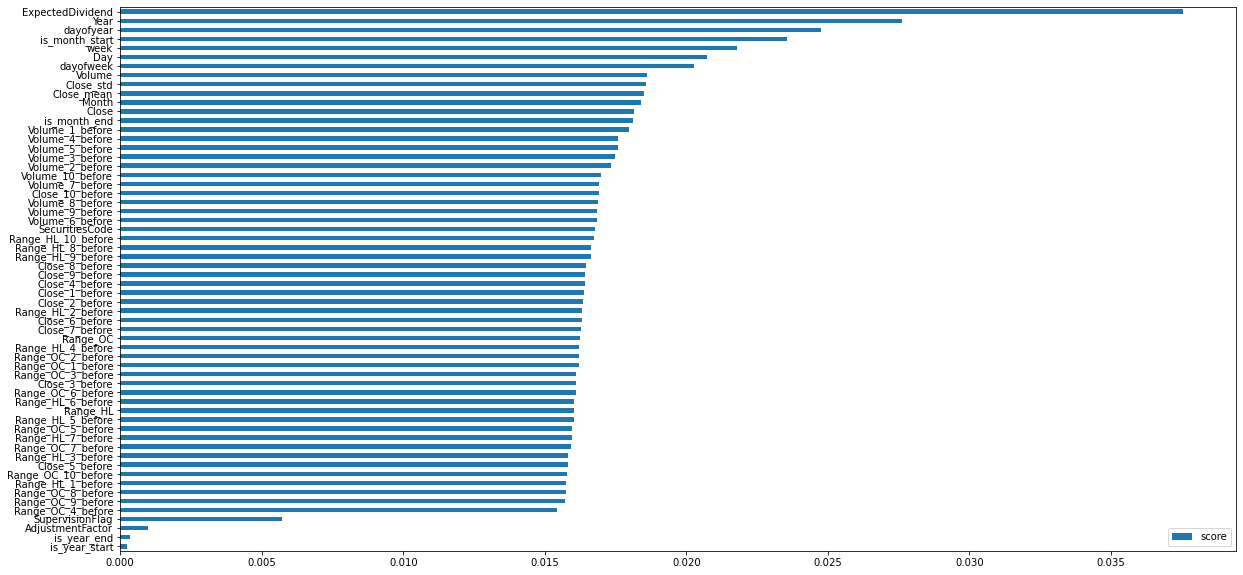

In [35]:
sorted_idx = np.argsort(mean_fi.values)[::-1]

data = pd.DataFrame(data=mean_fi.values[sorted_idx], index= mean_fi.keys()[sorted_idx], columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh', figsize = (20,10))

In [36]:
import seaborn as sb

<AxesSubplot:>

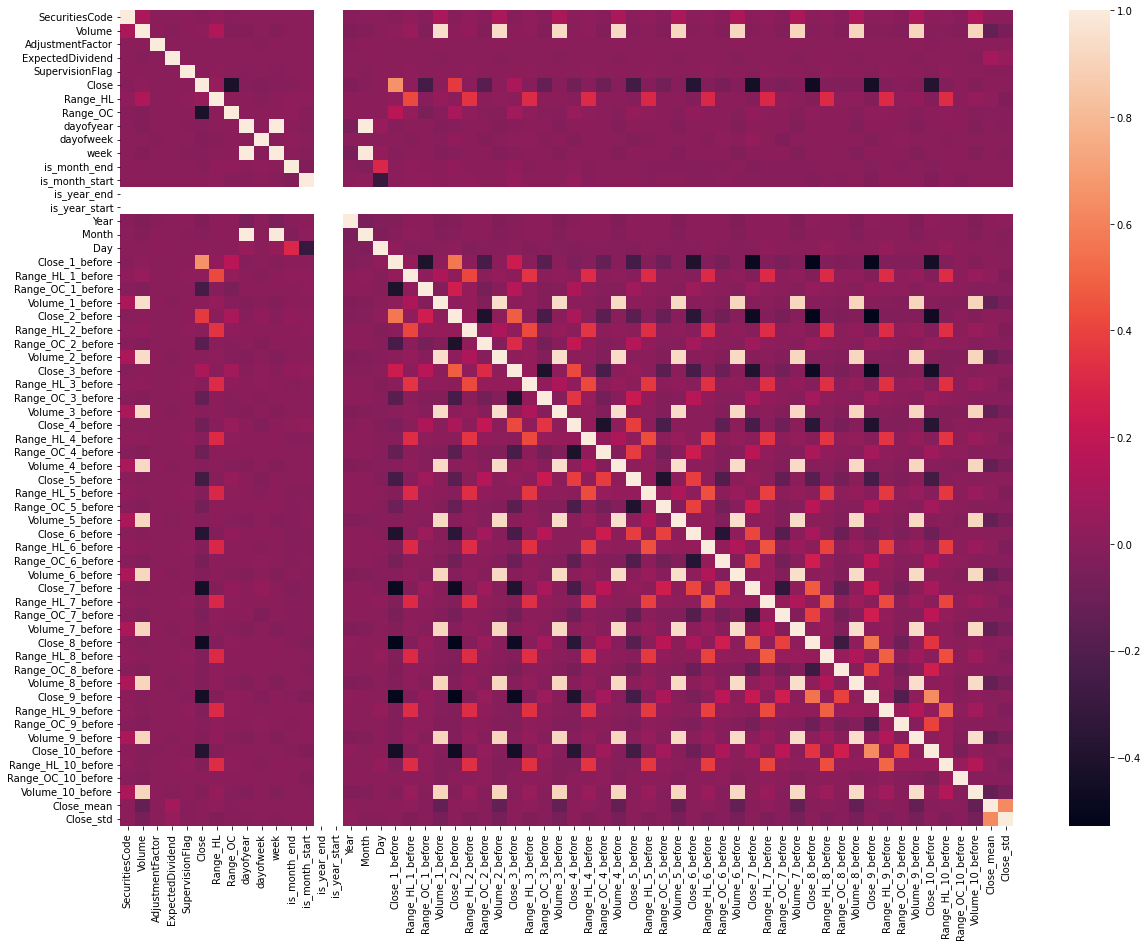

In [37]:
corr_matrix = train_df[list(featureCols)].corr()
plt.subplots(figsize=(20,15))
sb.heatmap(corr_matrix)

In [38]:
corr_matrix

,SecuritiesCode,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Close,Range_HL,Range_OC,dayofyear,dayofweek,...,Close_9_before,Range_HL_9_before,Range_OC_9_before,Volume_9_before,Close_10_before,Range_HL_10_before,Range_OC_10_before,Volume_10_before,Close_mean,Close_std
SecuritiesCode,1.000000,0.113305,0.001784,1.483864e-03,0.008706,-0.005327,0.022700,-0.005209,-1.191068e-03,0.000412,...,0.005911,0.020131,-0.004511,0.113857,0.006691,0.018083,-0.004360,0.113892,0.007284,0.000553
Volume,0.113305,1.000000,0.004976,-1.082367e-02,0.013457,0.018042,0.133193,-0.016587,-1.674331e-02,0.001194,...,-0.010167,-0.006014,-0.017533,0.912108,-0.010166,-0.011952,-0.017011,0.910651,-0.128638,-0.061217
AdjustmentFactor,0.001784,0.004976,1.000000,-7.916208e-05,-0.000359,0.001215,0.000500,-0.001565,4.901692e-03,-0.005076,...,-0.001021,0.000007,-0.001603,0.004024,-0.003175,-0.000947,-0.001185,0.003512,-0.001203,-0.001073
ExpectedDividend,0.001484,-0.010824,-0.000079,1.000000e+00,-0.000539,0.002409,0.002686,-0.001823,7.039074e-07,-0.002234,...,-0.000918,0.002526,-0.000759,-0.011381,-0.000957,0.002527,0.001125,-0.011346,0.087879,0.046933
SupervisionFlag,0.008706,0.013457,-0.000359,-5.389251e-04,1.000000,0.006670,0.017716,0.001616,-3.275931e-03,-0.000098,...,-0.005592,0.019598,0.003079,0.014464,-0.007154,0.022809,0.002551,0.014492,-0.006103,-0.005012
Close,-0.005327,0.018042,0.001215,2.408692e-03,0.006670,1.000000,0.049950,-0.416831,-1.190213e-02,-0.016906,...,-0.444339,-0.023705,-0.003766,-0.020661,-0.382326,-0.024304,0.011240,-0.020449,0.008508,0.000694
Range_HL,0.022700,0.133193,0.000500,2.686371e-03,0.017716,0.049950,1.000000,0.011167,1.424613e-02,-0.014302,...,-0.018656,0.312805,0.016328,0.028717,-0.020757,0.319483,0.013296,0.039451,0.016239,-0.031414
Range_OC,-0.005209,-0.016587,-0.001565,-1.822833e-03,0.001616,-0.416831,0.011167,1.000000,8.551590e-03,0.005750,...,0.018830,0.018841,0.005295,-0.010006,0.011893,0.020254,0.013344,-0.010161,-0.005396,-0.003353
dayofyear,-0.001191,-0.016743,0.004902,7.039074e-07,-0.003276,-0.011902,0.014246,0.008552,1.000000e+00,0.000966,...,0.003977,0.005460,0.001887,-0.023298,-0.001058,0.004645,0.003890,-0.024021,0.001665,-0.010832
dayofweek,0.000412,0.001194,-0.005076,-2.233530e-03,-0.000098,-0.016906,-0.014302,0.005750,9.663279e-04,1.000000,...,-0.019555,-0.001896,0.016058,0.000329,-0.002107,-0.007973,-0.000367,-0.000282,0.000111,-0.000739


In [39]:
_r, _c = np.where(np.abs(corr_matrix) > 0.8)

In [40]:
np.array(corr_matrix)[1, 25]

0.9355545795675425

In [41]:
np.array([_r[np.where(_r != _c)[0]], _c[np.where(_r != _c)[0]]]).T

array([[ 1, 21],
       [ 1, 25],
       [ 1, 29],
       [ 1, 33],
       [ 1, 37],
       [ 1, 41],
       [ 1, 45],
       [ 1, 49],
       [ 1, 53],
       [ 1, 57],
       [ 8, 10],
       [ 8, 16],
       [10,  8],
       [10, 16],
       [16,  8],
       [16, 10],
       [21,  1],
       [21, 25],
       [21, 29],
       [21, 33],
       [21, 37],
       [21, 41],
       [21, 45],
       [21, 49],
       [21, 53],
       [21, 57],
       [25,  1],
       [25, 21],
       [25, 29],
       [25, 33],
       [25, 37],
       [25, 41],
       [25, 45],
       [25, 49],
       [25, 53],
       [25, 57],
       [29,  1],
       [29, 21],
       [29, 25],
       [29, 33],
       [29, 37],
       [29, 41],
       [29, 45],
       [29, 49],
       [29, 53],
       [29, 57],
       [33,  1],
       [33, 21],
       [33, 25],
       [33, 29],
       [33, 37],
       [33, 41],
       [33, 45],
       [33, 49],
       [33, 53],
       [33, 57],
       [37,  1],
       [37, 21],
       [37, 25

In [42]:
_r

array([ 0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  3,  4,  5,  6,
        7,  8,  8,  8,  9, 10, 10, 10, 11, 12, 15, 16, 16, 16, 17, 18, 19,
       20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 23, 24, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 27, 28, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 30, 31, 32, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 34, 35, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
       38, 39, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 43, 44,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 46, 47, 48, 49, 49, 49,
       49, 49, 49, 49, 49, 49, 49, 49, 50, 51, 52, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 53, 54, 55, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57,
       57, 57, 58, 59])

In [43]:
couple_feat_found = np.array([
    featureCols[1:][_r[np.where(_r != _c)[0]]], 
    featureCols[1:][_c[np.where(_r != _c)[0]]]
]).T
couple_feat_found

array([['Volume', 'Volume_1_before'],
       ['Volume', 'Volume_2_before'],
       ['Volume', 'Volume_3_before'],
       ['Volume', 'Volume_4_before'],
       ['Volume', 'Volume_5_before'],
       ['Volume', 'Volume_6_before'],
       ['Volume', 'Volume_7_before'],
       ['Volume', 'Volume_8_before'],
       ['Volume', 'Volume_9_before'],
       ['Volume', 'Volume_10_before'],
       ['dayofyear', 'week'],
       ['dayofyear', 'Month'],
       ['week', 'dayofyear'],
       ['week', 'Month'],
       ['Month', 'dayofyear'],
       ['Month', 'week'],
       ['Volume_1_before', 'Volume'],
       ['Volume_1_before', 'Volume_2_before'],
       ['Volume_1_before', 'Volume_3_before'],
       ['Volume_1_before', 'Volume_4_before'],
       ['Volume_1_before', 'Volume_5_before'],
       ['Volume_1_before', 'Volume_6_before'],
       ['Volume_1_before', 'Volume_7_before'],
       ['Volume_1_before', 'Volume_8_before'],
       ['Volume_1_before', 'Volume_9_before'],
       ['Volume_1_before', 'Vol

In [44]:
corr_matrix[couple_feat_found[0][0]][couple_feat_found[0][1]]

0.9472583533074668

<AxesSubplot:>

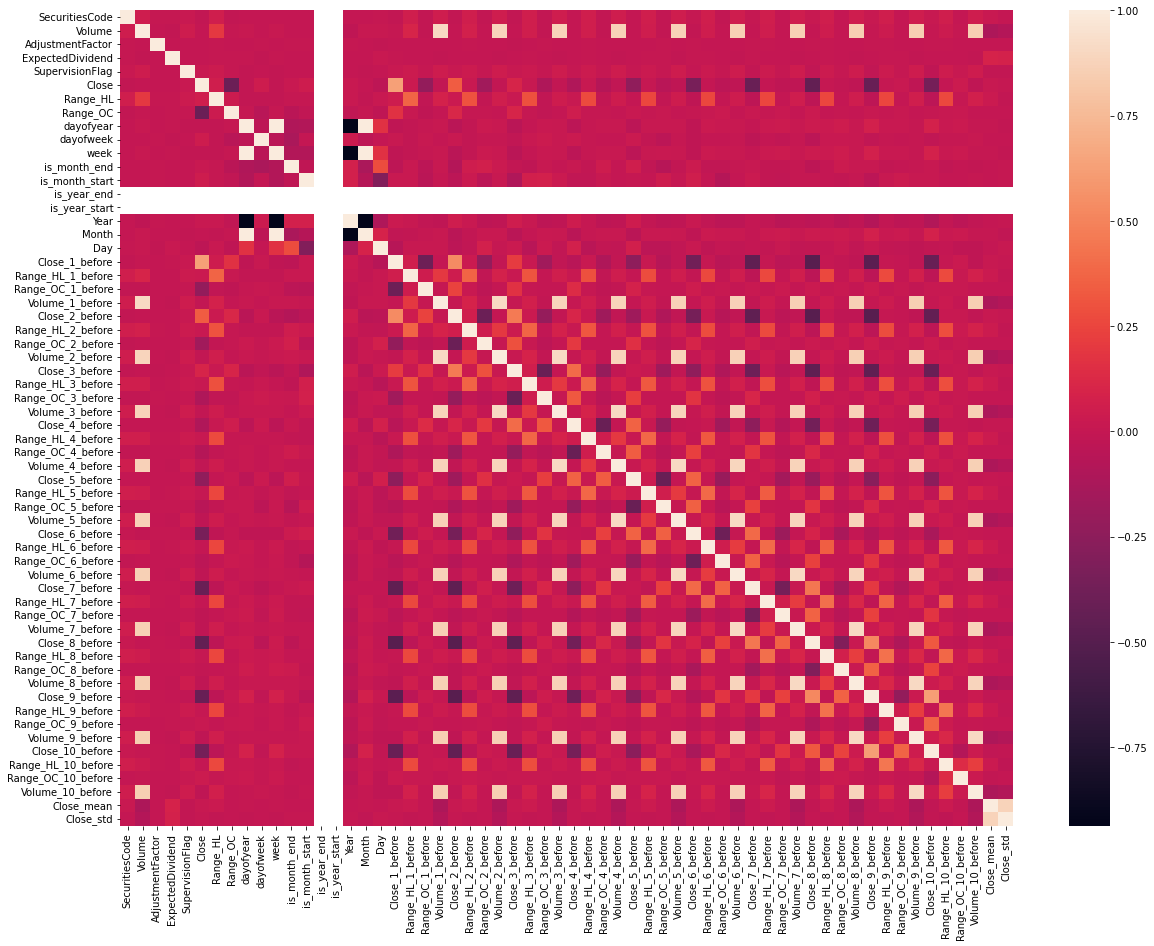

In [45]:
corr_matrix = X_valid.corr()
plt.subplots(figsize=(20,15))
sb.heatmap(corr_matrix)

In [46]:
corr_matrix

,SecuritiesCode,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Close,Range_HL,Range_OC,dayofyear,dayofweek,...,Close_9_before,Range_HL_9_before,Range_OC_9_before,Volume_9_before,Close_10_before,Range_HL_10_before,Range_OC_10_before,Volume_10_before,Close_mean,Close_std
SecuritiesCode,1.000000,0.052792,0.001758,0.004467,0.021567,-0.012919,0.059332,-0.008668,0.000951,-0.000081,...,0.012467,0.058360,-0.004419,0.053385,0.014006,0.056578,-0.002213,0.053751,0.017236,0.000836
Volume,0.052792,1.000000,-0.002056,-0.007806,0.043004,-0.001855,0.194825,0.005716,0.012421,-0.000008,...,0.004687,0.038665,-0.002701,0.854058,0.007750,0.032747,0.002731,0.851968,-0.109652,-0.077279
AdjustmentFactor,0.001758,-0.002056,1.000000,0.000146,0.000784,-0.001970,0.002027,-0.000384,-0.005356,0.003821,...,0.003374,0.002410,0.000032,-0.001638,0.002902,0.001682,-0.002697,-0.002183,0.000934,-0.001123
ExpectedDividend,0.004467,-0.007806,0.000146,1.000000,-0.001291,-0.000233,0.001433,0.001379,0.001518,-0.010431,...,-0.003356,0.003112,0.002863,-0.009348,0.000217,0.001224,0.001022,-0.010104,0.089685,0.078536
SupervisionFlag,0.021567,0.043004,0.000784,-0.001291,1.000000,0.021375,0.034423,0.003098,-0.006853,-0.000551,...,-0.019201,0.031999,0.005542,0.043221,-0.023470,0.043129,0.012601,0.042971,-0.013334,-0.012930
Close,-0.012919,-0.001855,-0.001970,-0.000233,0.021375,1.000000,0.055970,-0.399828,-0.007304,0.046175,...,-0.422174,0.002280,0.018316,-0.023997,-0.357409,-0.003315,0.034172,-0.024905,0.012274,0.007172
Range_HL,0.059332,0.194825,0.002027,0.001433,0.034423,0.055970,1.000000,0.035356,-0.011618,-0.012484,...,-0.036482,0.255253,-0.002769,0.060286,-0.036742,0.262009,0.006319,0.068248,0.028475,-0.013883
Range_OC,-0.008668,0.005716,-0.000384,0.001379,0.003098,-0.399828,0.035356,1.000000,0.003716,-0.053219,...,0.008943,0.006282,0.014747,0.000403,0.003763,0.010835,0.016964,-0.000044,-0.001061,-0.001528
dayofyear,0.000951,0.012421,-0.005356,0.001518,-0.006853,-0.007304,-0.011618,0.003716,1.000000,-0.035295,...,0.071450,0.021598,0.023530,0.007232,0.082018,0.020728,0.024814,0.004600,0.002679,-0.012881
dayofweek,-0.000081,-0.000008,0.003821,-0.010431,-0.000551,0.046175,-0.012484,-0.053219,-0.035295,1.000000,...,-0.014125,0.005786,-0.001854,0.005885,-0.016200,0.004951,0.006959,0.012148,0.000284,0.001132


<AxesSubplot:>

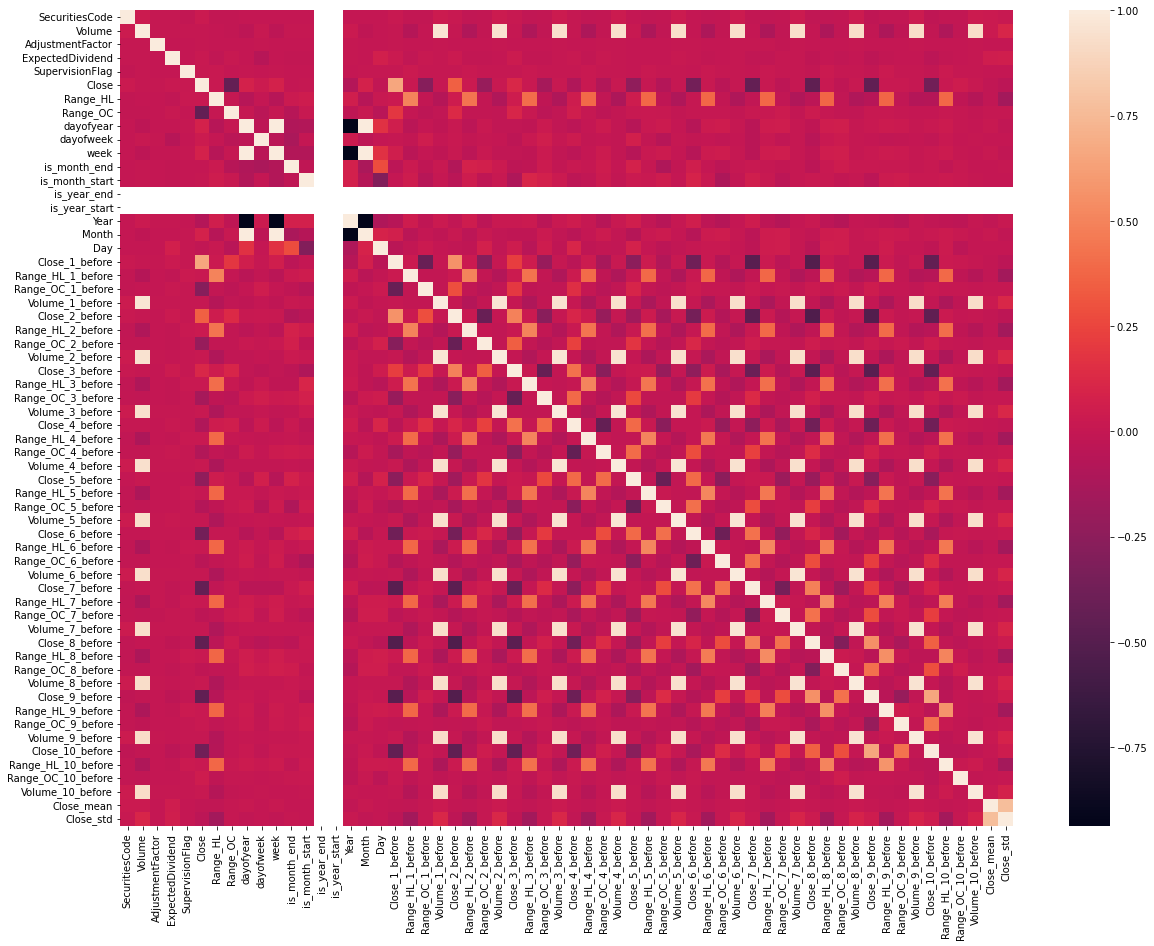

In [47]:
corr_matrix = test_df[featureCols].corr()
plt.subplots(figsize=(20,15))
sb.heatmap(corr_matrix)

In [48]:
train_df.sort_values(by=['SecuritiesCode', 'Date'])

,Date,SecuritiesCode,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,CloseT2,Close,CloseT1,...,Close_9_before,Range_HL_9_before,Range_OC_9_before,Volume_9_before,Close_10_before,Range_HL_10_before,Range_OC_10_before,Volume_10_before,Close_mean,Close_std
0,2017-01-19,1301,9.487972,1.0,-1.0,False,-0.006211,-0.115673,-1.037067,0.630218,...,0.674094,0.526511,0.219380,9.792556,0.849597,1.096898,-0.351007,10.354563,2722.636364,22.791545
1839,2017-01-20,1301,10.165852,1.0,-1.0,False,0.002574,0.863565,0.661128,0.549588,...,0.794976,1.070785,-0.267696,9.898475,0.705744,0.535392,0.223080,9.792556,2722.181818,22.413470
3684,2017-01-23,1301,9.441452,1.0,-1.0,False,0.001467,0.479752,-0.025031,0.296195,...,1.259870,0.871897,-0.137668,10.094108,0.892755,1.101343,-0.275336,9.898475,2720.545455,21.791575
5538,2017-01-24,1301,9.966462,1.0,-1.0,False,0.000732,0.650343,0.364192,0.554960,...,1.222646,0.715378,0.143076,9.137770,1.365721,0.906145,-0.143076,10.094108,2719.363636,20.967941
7389,2017-01-25,1301,9.622450,1.0,-1.0,False,-0.002195,0.478269,0.686624,0.790802,...,0.686624,2.291904,0.729242,10.264652,1.415866,0.781331,0.156266,9.137770,2717.818182,19.198011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4565395,2021-11-29,25935,10.445812,1.0,-1.0,False,-0.010239,-3.358442,-1.933648,-2.289847,...,1.373908,0.559740,-0.152656,9.740969,1.272137,0.305313,0.000000,9.705037,2096.000000,19.651972
4567421,2021-11-30,25935,9.560997,1.0,-1.0,False,-0.018719,-4.448809,-1.760469,-2.717336,...,1.155696,0.501216,0.364521,9.928180,1.520217,0.501216,-0.136695,9.740969,2089.636364,21.946629
4569462,2021-12-01,25935,10.494048,1.0,-1.0,False,0.003012,-3.269296,-2.011600,-3.505114,...,0.936126,0.589545,0.510939,9.674074,1.329156,0.432333,0.314424,9.928180,2081.181818,25.443342
4571490,2021-12-02,25935,11.278468,1.0,-1.0,False,-0.001502,-2.173411,-2.260347,-2.086475,...,0.811407,0.376725,0.202852,10.056209,1.014258,0.434682,0.376725,9.674074,2070.000000,34.507970


<AxesSubplot:>

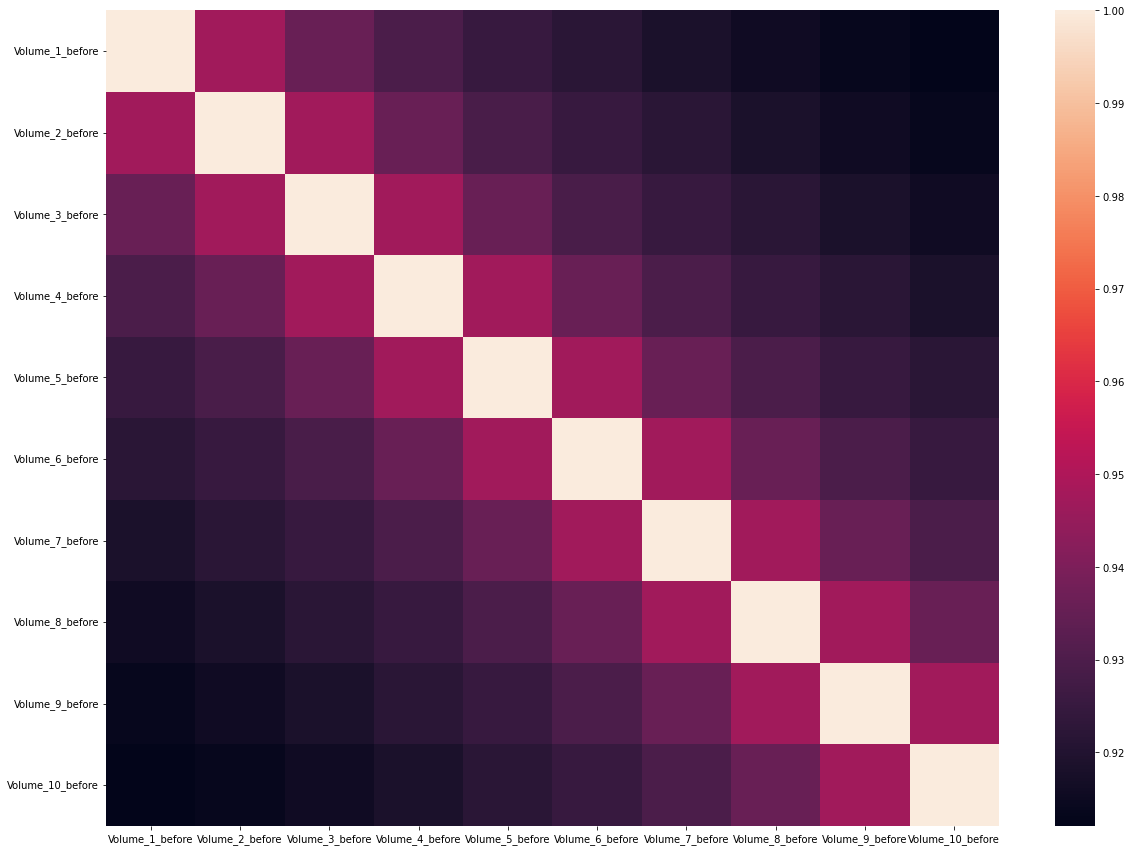

In [49]:
corr_matrix = train_df[['Volume_' + str(i + 1) +'_before' for i in range(N_past)]].corr()
plt.subplots(figsize=(20,15))
sb.heatmap(corr_matrix)

#### feature selection

In [50]:
feature_important_list = pd.read_csv('./result_feature_important.csv')

In [51]:
feature_important_list

,SecuritiesCode,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Close,Range_HL,Range_OC,dayofyear,dayofweek,...,Close_9_before,Range_HL_9_before,Range_OC_9_before,Volume_9_before,Close_10_before,Range_HL_10_before,Range_OC_10_before,Volume_10_before,Close_mean,Close_std
0,0.019415,0.020082,0.000000,0.037449,0.000000,0.017623,0.017300,0.015674,0.019827,0.017156,...,0.016672,0.017094,0.014866,0.016889,0.016103,0.016050,0.015110,0.019008,0.020335,0.020985
1,0.017119,0.018598,0.001665,0.039838,0.000000,0.017235,0.016239,0.016694,0.022217,0.018685,...,0.016283,0.016605,0.016731,0.016578,0.016572,0.016909,0.016422,0.017271,0.017262,0.019636
2,0.014321,0.020592,0.000000,0.012083,0.000000,0.019329,0.017546,0.017307,0.028538,0.024866,...,0.018492,0.017997,0.017397,0.020532,0.015531,0.018656,0.015972,0.016759,0.021094,0.020674
3,0.017245,0.018399,0.000000,0.037601,0.015477,0.017750,0.016496,0.016225,0.026760,0.019008,...,0.016190,0.016697,0.015570,0.016957,0.016880,0.016778,0.015239,0.017020,0.018585,0.018392
4,0.016878,0.018028,0.000000,0.030391,0.013896,0.016761,0.016316,0.016450,0.023795,0.020154,...,0.016405,0.016675,0.015733,0.016830,0.015922,0.016811,0.015862,0.016164,0.018810,0.017907
5,0.016654,0.019559,0.000000,0.040719,0.016293,0.018366,0.016673,0.017497,0.022452,0.018356,...,0.016030,0.015886,0.015434,0.016789,0.017912,0.015643,0.015661,0.016128,0.020916,0.017562
6,0.015594,0.017760,0.001073,0.035054,0.000000,0.018631,0.016541,0.016525,0.026584,0.020286,...,0.016487,0.016379,0.015732,0.016297,0.017614,0.017285,0.015813,0.016718,0.017708,0.018918
7,0.018024,0.018584,0.000620,0.029473,0.000024,0.017821,0.016535,0.016923,0.022856,0.018536,...,0.016711,0.016854,0.016330,0.017785,0.017045,0.017161,0.016052,0.017871,0.019230,0.019390
8,0.016371,0.015803,0.005975,0.108504,0.016524,0.015722,0.014416,0.012895,0.018431,0.017678,...,0.014991,0.014646,0.014039,0.014367,0.014631,0.015187,0.013446,0.015936,0.016874,0.016519
9,0.013982,0.018219,0.001365,0.018716,0.001788,0.019841,0.014925,0.016899,0.031644,0.027863,...,0.016608,0.017281,0.014738,0.017383,0.017157,0.016871,0.016211,0.016118,0.016388,0.019088


In [52]:
mean_fi = feature_important_list.mean(axis= 0)
mean_fi

SecuritiesCode        0.016762
Volume                0.018608
AdjustmentFactor      0.000975
ExpectedDividend      0.037545
SupervisionFlag       0.005712
Close                 0.018156
Range_HL              0.016037
Range_OC              0.016251
dayofyear             0.024766
dayofweek             0.020252
week                  0.021785
is_month_end          0.018122
is_month_start        0.023538
is_year_end           0.000333
is_year_start         0.000234
Year                  0.027629
Month                 0.018405
Day                   0.020743
Close_1_before        0.016379
Range_HL_1_before     0.015748
Range_OC_1_before     0.016192
Volume_1_before       0.017975
Close_2_before        0.016365
Range_HL_2_before     0.016330
Range_OC_2_before     0.016201
Volume_2_before       0.017328
Close_3_before        0.016094
Range_HL_3_before     0.015816
Range_OC_3_before     0.016099
Volume_3_before       0.017464
Close_4_before        0.016423
Range_HL_4_before     0.016206
Range_OC

In [53]:
mean_fi.values

array([0.01676178, 0.01860819, 0.00097471, 0.03754463, 0.00571189,
       0.0181558 , 0.01603732, 0.01625056, 0.02476589, 0.02025162,
       0.02178469, 0.01812176, 0.02353784, 0.0003331 , 0.00023443,
       0.02762891, 0.01840459, 0.0207432 , 0.01637878, 0.0157476 ,
       0.01619222, 0.01797538, 0.01636472, 0.01632971, 0.01620056,
       0.01732782, 0.01609374, 0.01581551, 0.01609928, 0.01746422,
       0.01642264, 0.01620563, 0.01542033, 0.01758137, 0.01580369,
       0.01603647, 0.01597522, 0.017567  , 0.01631764, 0.01604445,
       0.01609348, 0.01682673, 0.01628907, 0.01594996, 0.01591551,
       0.01692975, 0.01643728, 0.01664622, 0.01574216, 0.01687393,
       0.01643103, 0.01662365, 0.01572147, 0.01684934, 0.01690644,
       0.01673557, 0.01578147, 0.0169817 , 0.01849112, 0.01855922])

<AxesSubplot:>

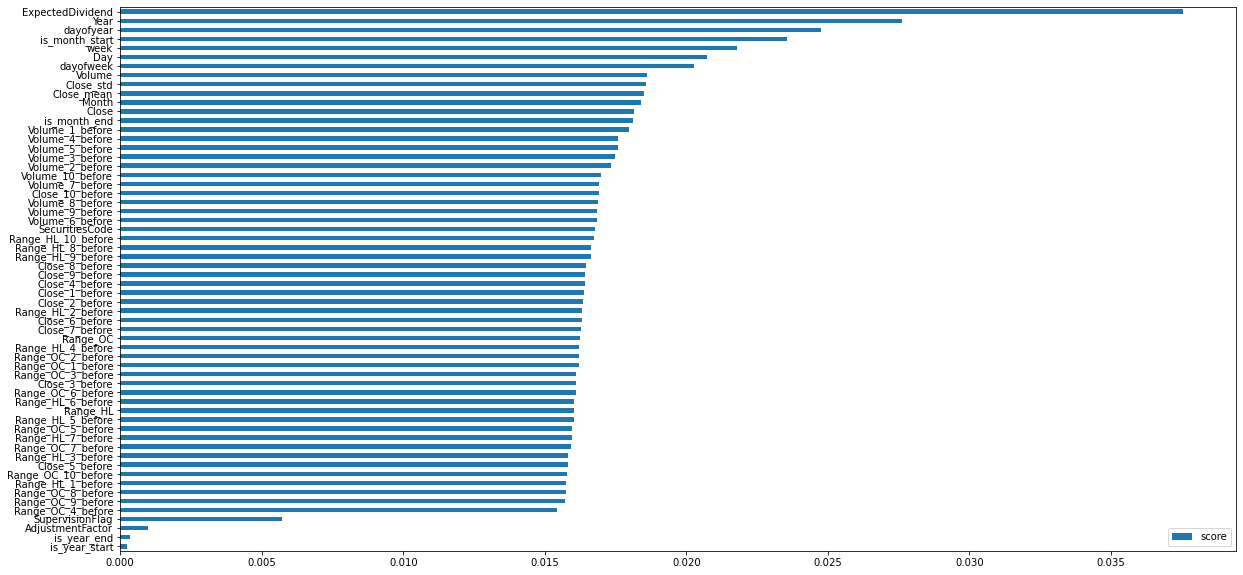

In [54]:
sorted_idx = np.argsort(mean_fi.values)[::-1]

data = pd.DataFrame(data=mean_fi.values[sorted_idx], index= mean_fi.keys()[sorted_idx], columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh', figsize = (20,10))

In [55]:
def FeaturesSelection(_df: pd.DataFrame, _fi: pd.Series, N_top: int, hasTarget: bool = True):
    df = _df.copy()
    fi = _fi.copy()

    keys_drop_date = fi[['dayofyear', 'week', 'Month']].sort_values().keys()[:2]
    df.drop(
        keys_drop_date,
        axis = 1,
        inplace= True
    )
    fi.drop(keys_drop_date, inplace= True)

    keys_drop_top_volume = fi[['Volume_' + str(i + 1) +'_before' for i in range(int(N_past / 2))]].sort_values().keys()[ : int(N_past / 2) - 1]
    df.drop(
        keys_drop_top_volume,
        axis = 1,
        inplace= True
    )
    fi.drop(keys_drop_top_volume, inplace= True)

    keys_drop_bot_volume = fi[['Volume_' + str(i + 1) +'_before' for i in range(int(N_past / 2), N_past, 1)]].sort_values().keys()[ : N_past - int(N_past / 2) - 1]
    df.drop(
        keys_drop_bot_volume,
        axis = 1,
        inplace= True
    )
    fi.drop(keys_drop_bot_volume, inplace= True)

    df = df[list(fi.sort_values(ascending= False).keys()[: N_top]) + hasTarget * ['Target', 'CloseT1', 'CloseT2']]
    return df

In [56]:
train_df_N = FeaturesSelection(train_df, mean_fi, 30)
valid_df_N = FeaturesSelection(valid_df, mean_fi, 30)
test_df_N = FeaturesSelection(test_df, mean_fi, 30, hasTarget= False)

In [57]:
train_df_N.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4573509 entries, 0 to 4573508
Data columns (total 33 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ExpectedDividend    float64
 1   Year                int64  
 2   dayofyear           int64  
 3   is_month_start      bool   
 4   Day                 int64  
 5   dayofweek           int64  
 6   Volume              float64
 7   Close_std           float64
 8   Close_mean          float64
 9   Close               float64
 10  is_month_end        bool   
 11  Volume_1_before     float64
 12  Volume_10_before    float64
 13  Close_10_before     float64
 14  SecuritiesCode      int64  
 15  Range_HL_10_before  float64
 16  Range_HL_8_before   float64
 17  Range_HL_9_before   float64
 18  Close_8_before      float64
 19  Close_9_before      float64
 20  Close_4_before      float64
 21  Close_1_before      float64
 22  Close_2_before      float64
 23  Range_HL_2_before   float64
 24  Close_6_before      floa

In [58]:
valid_df_N.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233223 entries, 0 to 233222
Data columns (total 33 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ExpectedDividend    233223 non-null  float64
 1   Year                233223 non-null  int64  
 2   dayofyear           233223 non-null  int64  
 3   is_month_start      233223 non-null  bool   
 4   Day                 233223 non-null  int64  
 5   dayofweek           233223 non-null  int64  
 6   Volume              233223 non-null  float64
 7   Close_std           233223 non-null  float64
 8   Close_mean          233223 non-null  float64
 9   Close               233223 non-null  float64
 10  is_month_end        233223 non-null  bool   
 11  Volume_1_before     233223 non-null  float64
 12  Volume_10_before    233223 non-null  float64
 13  Close_10_before     233223 non-null  float64
 14  SecuritiesCode      233223 non-null  int64  
 15  Range_HL_10_before  233223 non-nul

In [59]:
test_df_N.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229952 entries, 0 to 229951
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ExpectedDividend    229952 non-null  float64
 1   Year                229952 non-null  int64  
 2   dayofyear           229952 non-null  int64  
 3   is_month_start      229952 non-null  bool   
 4   Day                 229952 non-null  int64  
 5   dayofweek           229952 non-null  int64  
 6   Volume              229952 non-null  float64
 7   Close_std           229952 non-null  float64
 8   Close_mean          229952 non-null  float64
 9   Close               229952 non-null  float64
 10  is_month_end        229952 non-null  bool   
 11  Volume_1_before     229952 non-null  float64
 12  Volume_10_before    229952 non-null  float64
 13  Close_10_before     229952 non-null  float64
 14  SecuritiesCode      229952 non-null  int64  
 15  Range_HL_10_before  229952 non-nul

In [60]:
train_df_N.to_csv('../input/3_after_EDA/' + str(N_past) + '/train_full.csv', index = False)
valid_df_N.to_csv('../input/3_after_EDA/' + str(N_past) + '/valid_full.csv', index = False)
test_df_N.to_csv('../input/3_after_EDA/' + str(N_past) + '/test_full.csv', index = False)
y_test_df.to_csv('../input/3_after_EDA/' + str(N_past) + '/y_test_full.csv', index = False)